NLTK punkt already available
NLTK punkt_tab already available
NLTK stopwords already available
ROUGE scoring available
COMPREHENSIVE CLINICAL TEXT SUMMARIZATION SYSTEM
Features:
  • Multi-model comparison (T5-Small, BART-Large-CNN, T5-Base)
  • Comprehensive evaluation metrics (ROUGE + alternatives)
  • SEPARATED advanced visualizations and analytics
  • Intelligent model selection
  • Production-ready summarization
🔧 Required packages: pandas, numpy, nltk, matplotlib, seaborn, transformers, torch, rouge-score, scikit-learn
 Required data: Clinical dataset with 'transcription' column
----------------------------------------------------------------------
Using device: cpu
 COMPREHENSIVE MULTI-MODEL CLINICAL TEXT SUMMARIZATION PIPELINE
 Features: T5-Small, BART-Large-CNN, T5-Base comparison
 Enhanced analytics, SEPARATED visualizations, and evaluation metrics
----------------------------------------------------------------------------------------------------
 STARTING COMPREHENSIVE MULTI

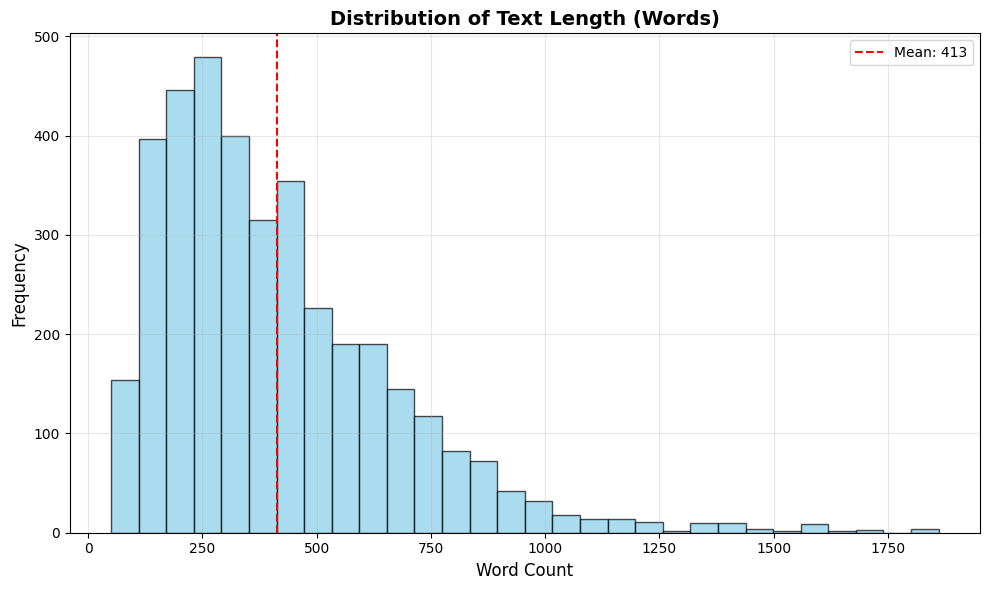

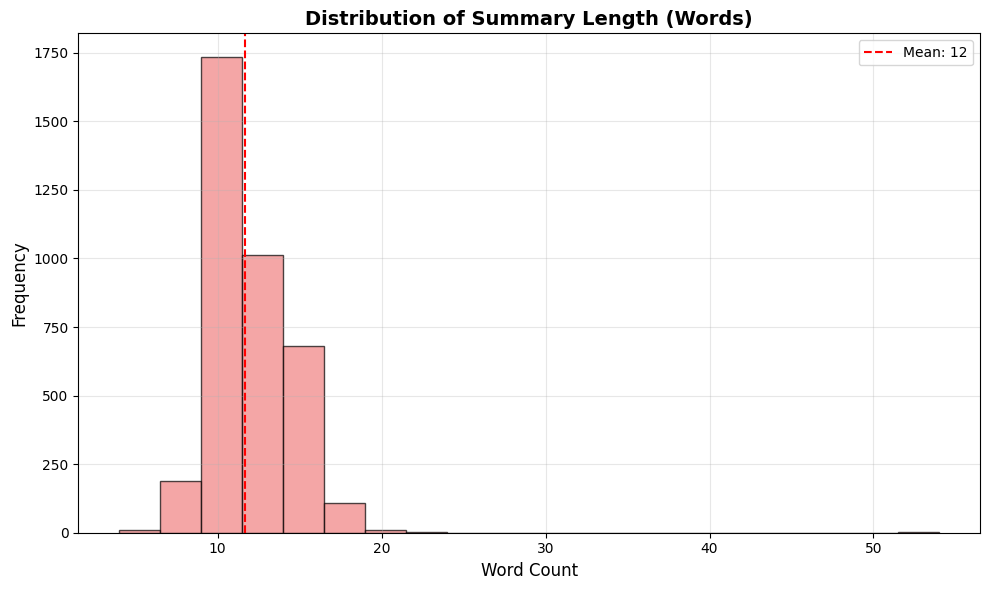

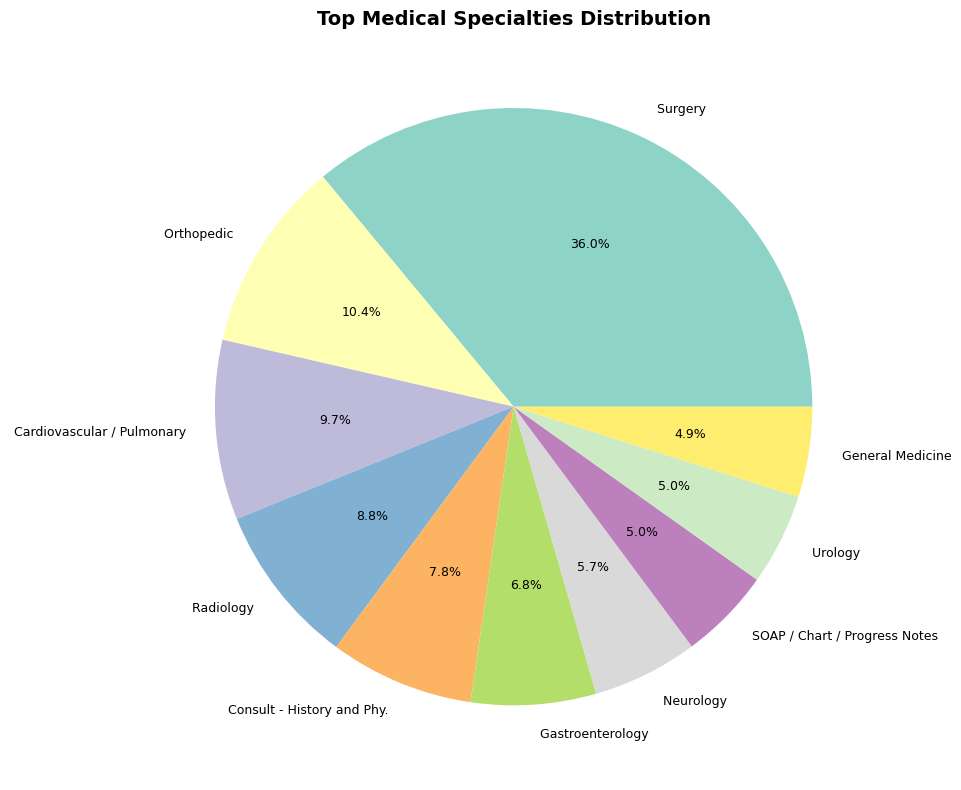

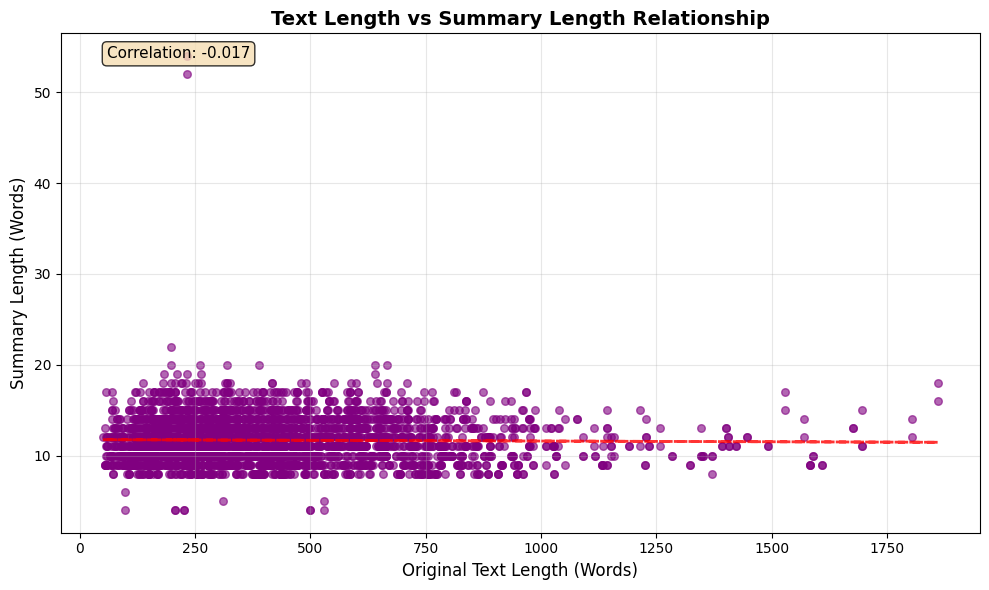

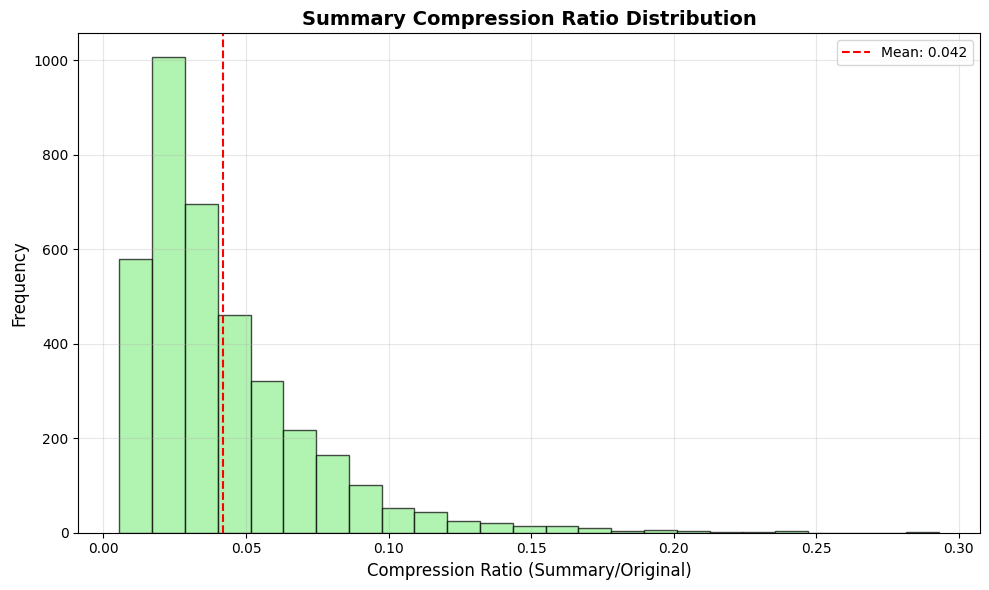

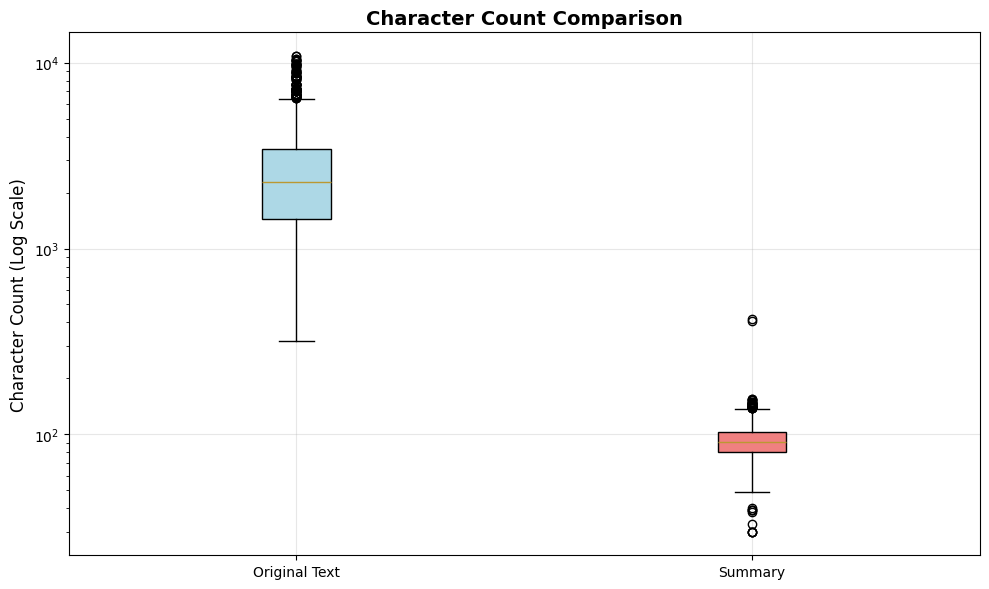

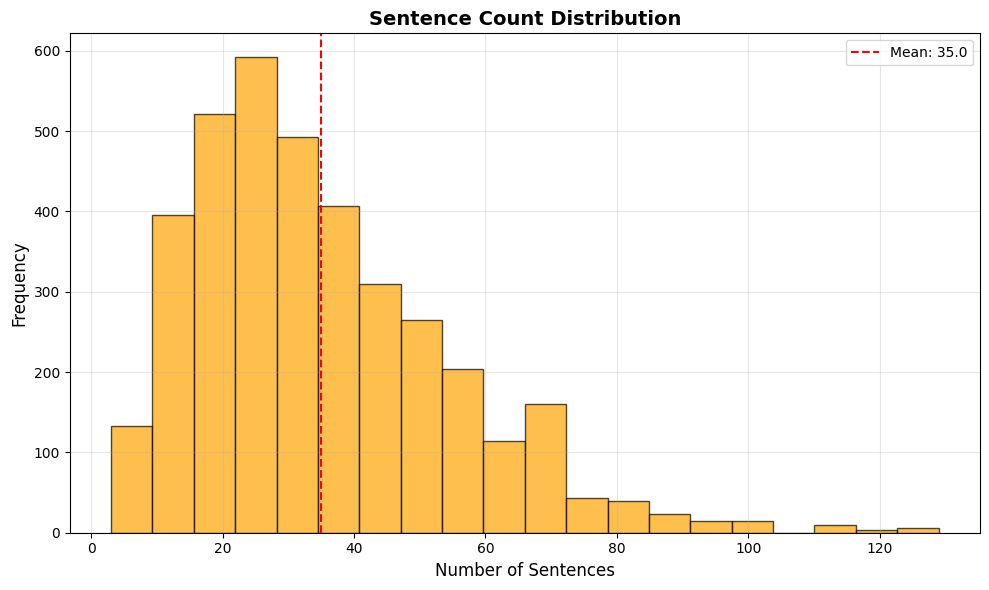

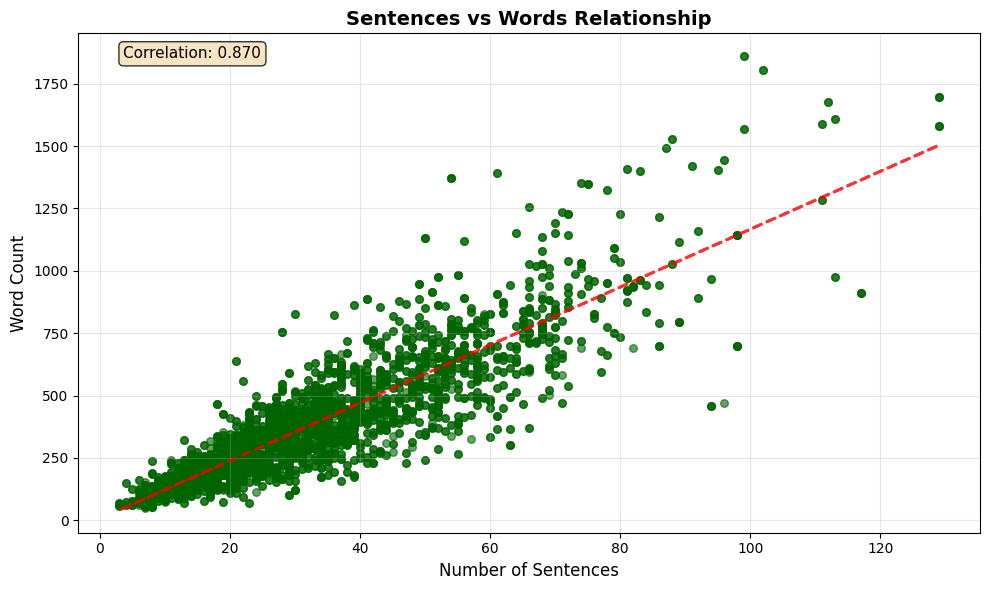

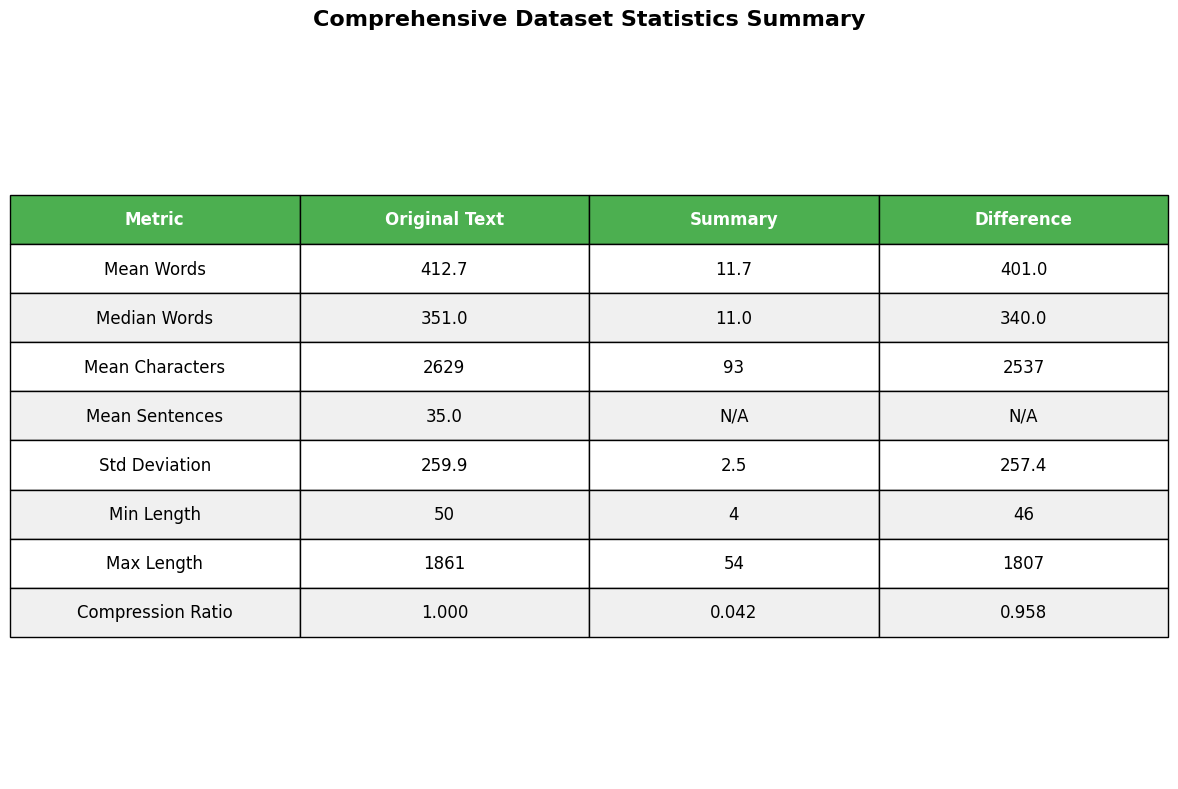


COMPREHENSIVE DATASET STATISTICS:
Dataset Overview:
- Total Records: 3,745
- Average Text Length: 412.7 words
- Average Summary Length: 11.7 words
- Average Compression Ratio: 0.042
- Text Length Range: 50 - 1861 words
- Summary Length Range: 4 - 54 words
- Number of Medical Specialties: 39
- Most Common Specialty:  Surgery

STEP 4: COMPREHENSIVE MULTI-MODEL PREPARATION

 Loading T5_SMALL: T5-Small: General purpose transformer model
Model: t5-small
  - Loading tokenizer...
  - Loading model...


Device set to use cpu


  - Creating pipeline...
Loaded successfully in 0.80s
  - Parameters: 60,506,624
  - Model Size: 230.8 MB

 Loading BART_LARGE: BART-Large-CNN: Optimized for summarization
Model: facebook/bart-large-cnn
  - Loading tokenizer...
  - Loading model...


Device set to use cpu


  - Creating pipeline...
Loaded successfully in 0.74s
  - Parameters: 406,290,432
  - Model Size: 1549.9 MB

 Loading T5_BASE: T5-Base: Larger general purpose transformer model
Model: t5-base
  - Loading tokenizer...
  - Loading model...


Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  - Creating pipeline...
Loaded successfully in 0.79s
  - Parameters: 222,903,552
  - Model Size: 850.3 MB

 MODEL LOADING SUMMARY:
Successfully loaded: 3 models
  - T5_SMALL, BART_LARGE, T5_BASE

STEP 5: INTELLIGENT DATA SPLITTING
✓ Stratified split by text length completed

📊 DATA SPLIT ANALYSIS:
- Training samples: 2,996
- Testing samples: 749
- Test ratio: 20.0%
- Train avg length: 412.1 words
- Test avg length: 414.9 words
 Split quality: Excellent (length difference: 2.8)

STEP 6: COMPREHENSIVE MULTI-MODEL SUMMARY GENERATION
Processing limited sample of 30 texts for demonstration

 Generating summaries with T5_SMALL...


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


    ✓ Processed 20/30 texts (Avg batch time: 3.32s)


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


    ✓ Processed 30/30 texts (Avg batch time: 3.04s)
  T5_SMALL PERFORMANCE:
    - Total time: 24.32s
    - Speed: 1.23 summaries/sec
    - Success rate: 100.0%

 Generating summaries with BART_LARGE...
    ✓ Processed 20/30 texts (Avg batch time: 14.24s)


Your max_length is set to 100, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


    ✓ Processed 30/30 texts (Avg batch time: 13.93s)
  BART_LARGE PERFORMANCE:
    - Total time: 111.41s
    - Speed: 0.27 summaries/sec
    - Success rate: 100.0%

 Generating summaries with T5_BASE...


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


    ✓ Processed 20/30 texts (Avg batch time: 9.61s)


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


    ✓ Processed 30/30 texts (Avg batch time: 8.85s)
  T5_BASE PERFORMANCE:
    - Total time: 70.79s
    - Speed: 0.42 summaries/sec
    - Success rate: 100.0%

 GENERATION PERFORMANCE COMPARISON:
Model           Speed (s/sec)   Success Rate    Avg Length     
------------------------------------------------------------
T5_SMALL        1.23            100.0          % 28.0           
BART_LARGE      0.27            100.0          % 31.9           
T5_BASE         0.42            100.0          % 30.2           

STEP 7: COMPREHENSIVE MULTI-MODEL EVALUATION

 Evaluating T5_SMALL...
  ROUGE SCORES:
    - ROUGE-1: 0.2121 ± 0.1332
    - ROUGE-2: 0.0878 ± 0.0953
    - ROUGE-L: 0.1716 ± 0.1205
  ⚡ PERFORMANCE:
    - Speed: 1.23 summaries/sec
    - Success Rate: 100.0%

 Evaluating BART_LARGE...
  ROUGE SCORES:
    - ROUGE-1: 0.2316 ± 0.1452
    - ROUGE-2: 0.0841 ± 0.1195
    - ROUGE-L: 0.1949 ± 0.1156
  ⚡ PERFORMANCE:
    - Speed: 0.27 summaries/sec
    - Success Rate: 100.0%

 Evaluating T5_

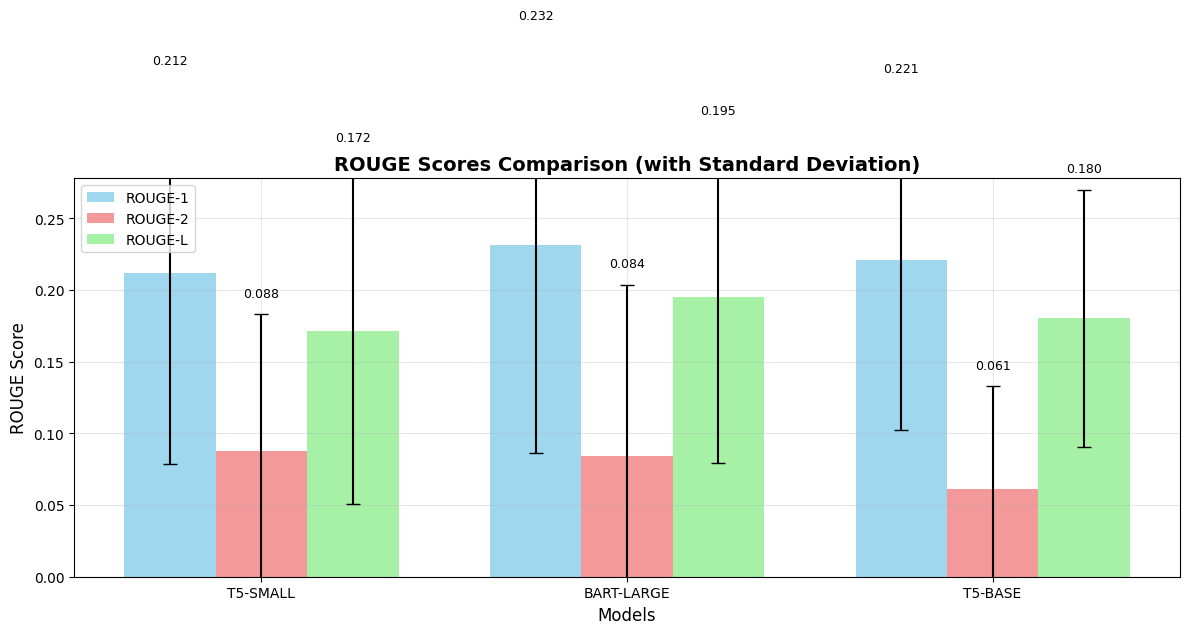

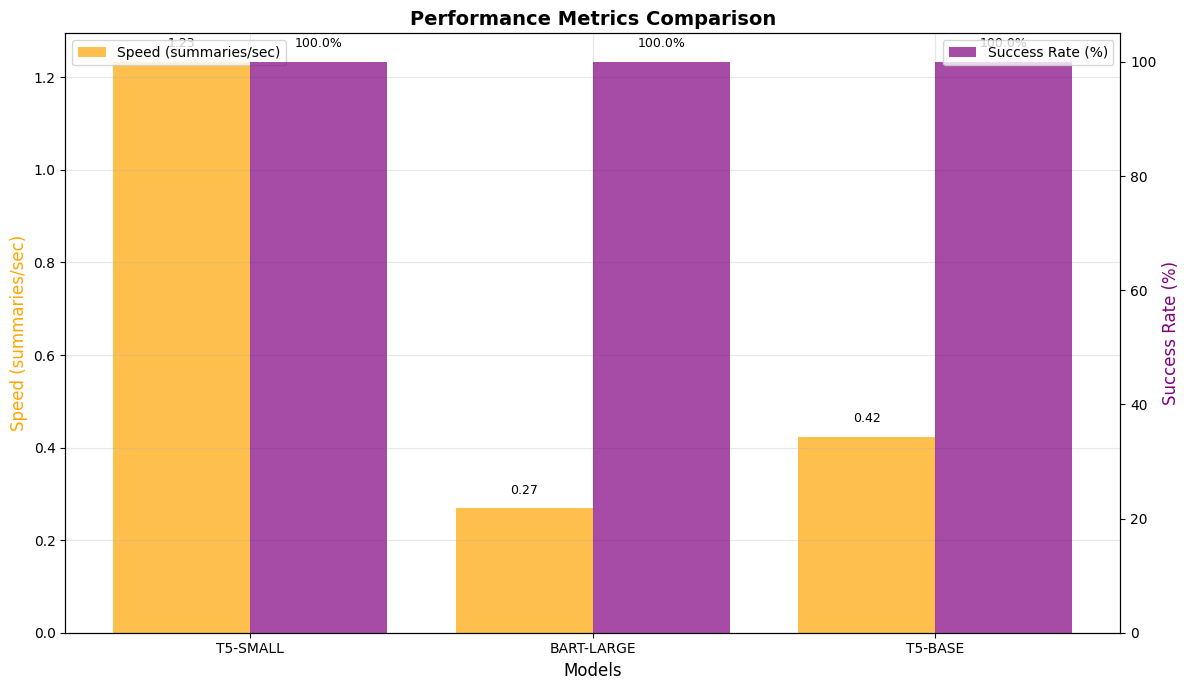

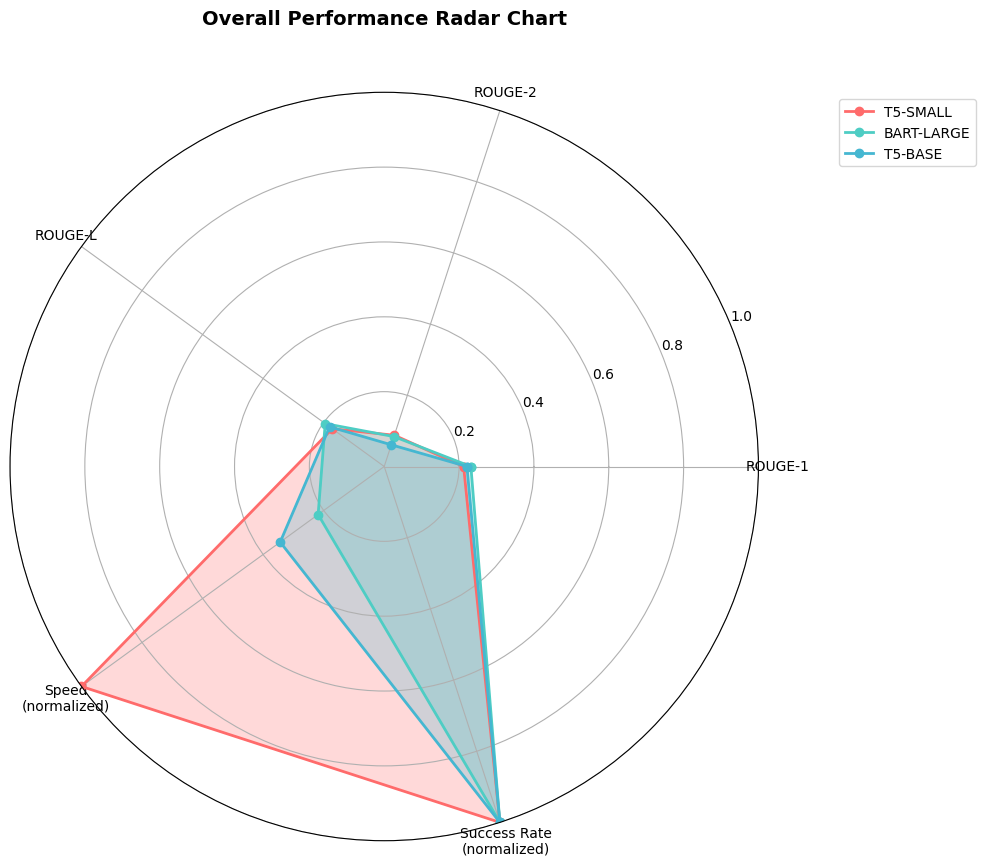

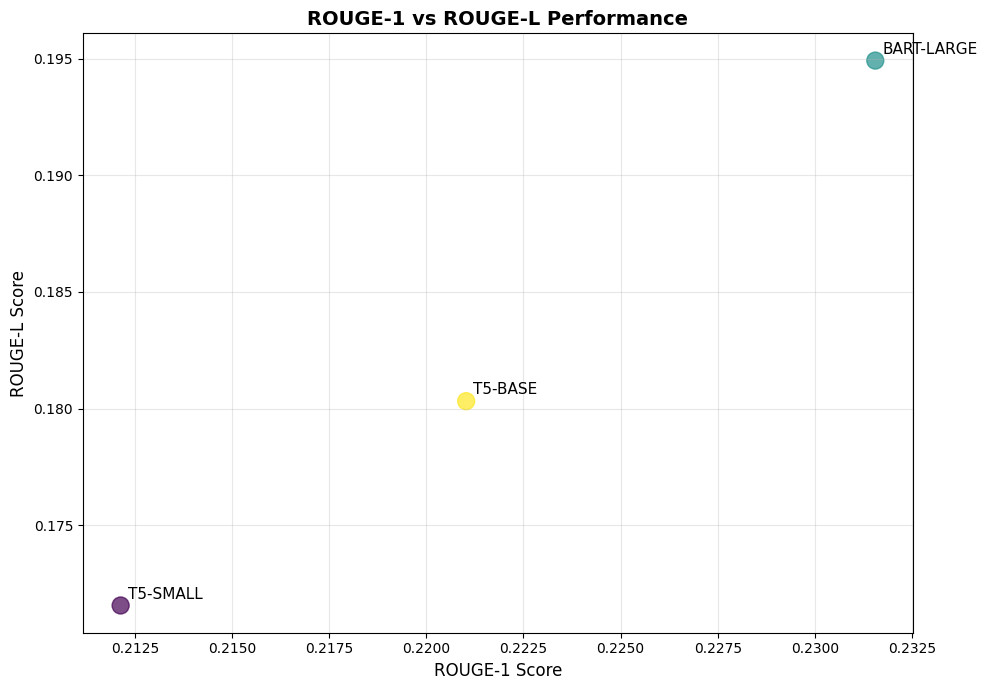

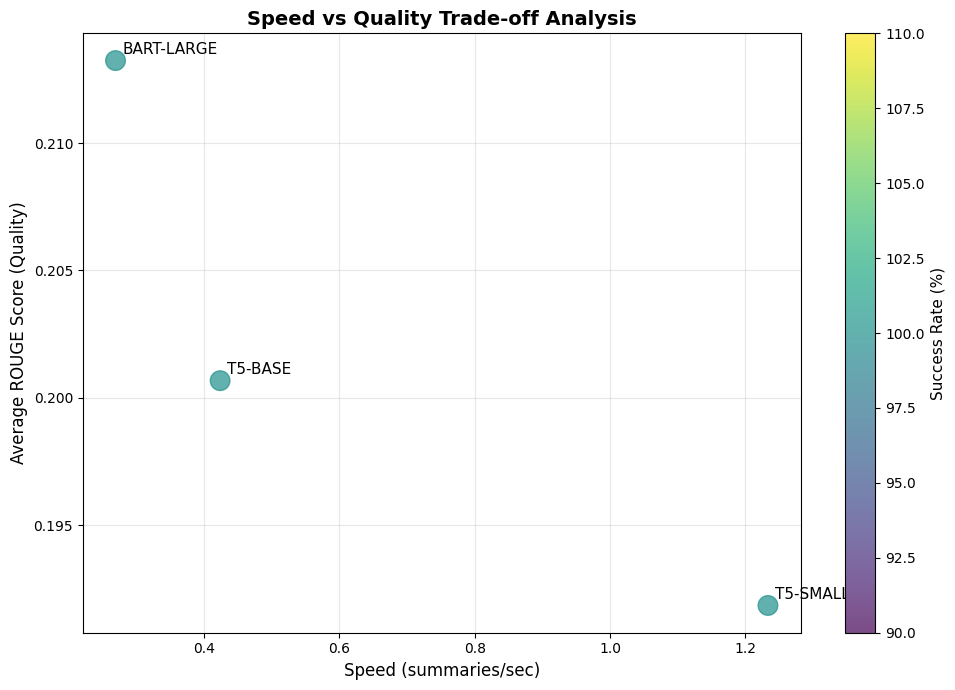

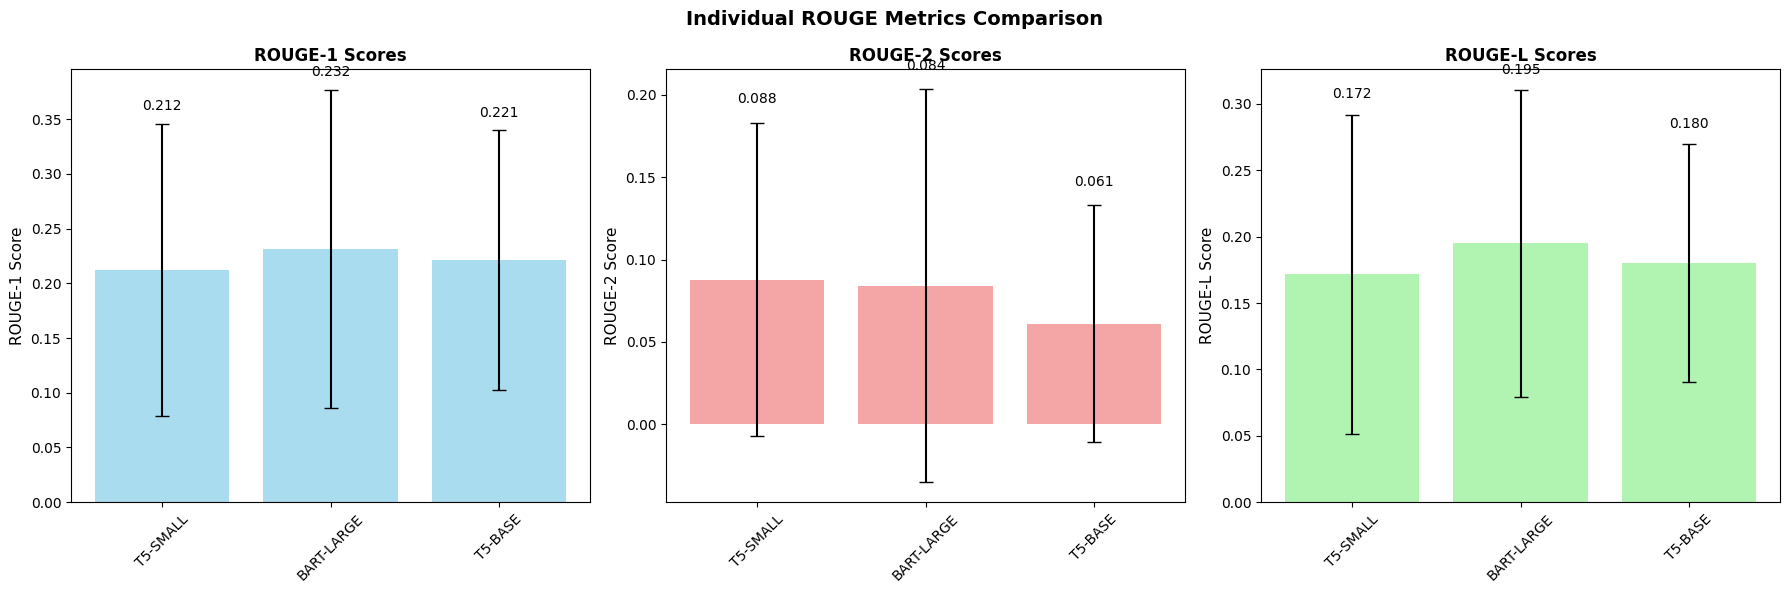

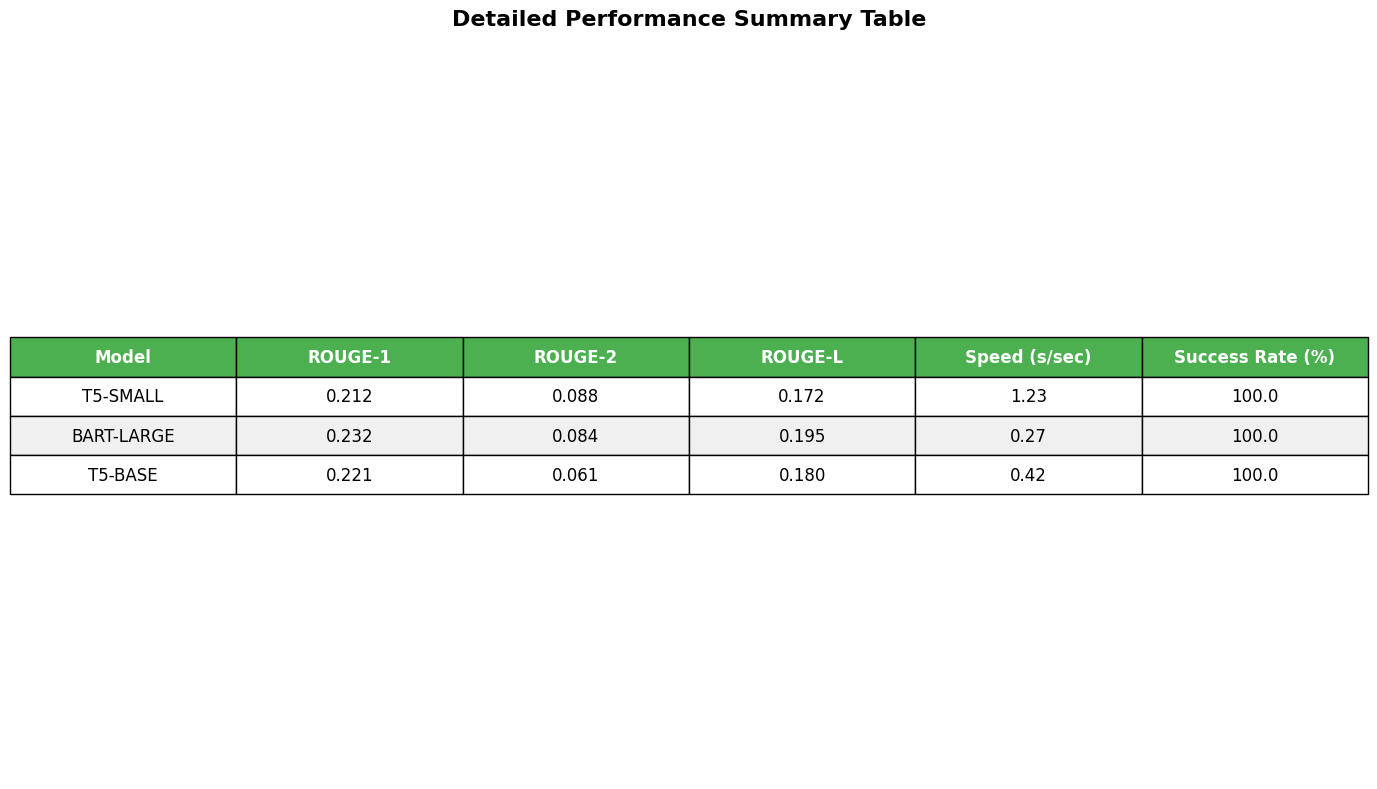

Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



STEP 9: DETAILED SAMPLE RESULTS - ALL MODELS

============================== SAMPLE 1 ==============================

 ORIGINAL TEXT (104 words):
preoperative diagnosis   refractory pneumonitis. postoperative diagnosis    refractory pneumonitis. procedure performed    bronchoscopy with bronchoalveolar lavage. anesthesia     mg of versed. indications    a -year-old man status post trauma  slightly prolonged respiratory failure status post tracheostomy  requires another bronchoscopy for further evaluation of refractory pneumonitis. procedure    the patient was sedated with  mg of versed that was placed on the endotracheal tube. bronchoscope...

 REFERENCE SUMMARY (11 words):
Patient presents with surgery, respiratory failure, bronchoalveolar lavage and refractory pneumonitis.

 GENERATED SUMMARIES:
   T5-SMALL (36 words): preoperative diagnosis refractory pneumonitis . procedure performed bronchoscopy with broncoalveolar lavage . anesthesia mg of versed . indications a -year-old man sta

Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


 Generated summary statistics:
  - Summary words: 21
  - Compression ratio: 0.233
  - Generation time: 0.796s

 ORIGINAL CLINICAL TEXT:

        SUBJECTIVE: This 45-year-old male presents with chest pain that started
        2 hours ago. The pain is described as crushing and radiates to the left arm.
        Patient has history of hypertension and diabetes. He reports associated
        shortness of breath and nausea.

        OBJEC...

 GENERATED SUMMARY:
the pain is described as crushing and radiates to the left arm . patient has history of hypertension and diabetes .

 SUMMARY ANALYTICS:
  - Model: T5_SMALL
  - Input length: 90 words
  - Summary length: 21 words
  - Compression ratio: 0.233
  - Generation time: 0.796 seconds

 COMPARISON: ALL MODELS ON SAME TEXT
------------------------------------------------------------
 Input text statistics:
  - Words: 90
  - Characters: 669
 Generated summary statistics:
  - Summary words: 21
  - Compression ratio: 0.233
  - Generation time: 0.

Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


 Generated summary statistics:
  - Summary words: 21
  - Compression ratio: 0.233
  - Generation time: 3.766s
 BART-LARGE: The patient has history of hypertension and diabetes. He reports associated shortness of breath and nausea. Physical examination reveals mild diaphoresis.
   (21 words, 3.766s)

 Input text statistics:
  - Words: 90
  - Characters: 669
 Generated summary statistics:
  - Summary words: 27
  - Compression ratio: 0.300
  - Generation time: 1.930s
 T5-BASE: the pain is described as crushing and radiates to the left arm . patient has history of hypertension and diabetes . physical examination reveals mild diaphoresis .
   (27 words, 1.930s)

 FINAL RECOMMENDATIONS
 Best Model: T5-SMALL
 Performance Score: 0.4169
 RECOMMENDATION: Fair performance - Requires improvement
 Consider additional training data or different model architectures

 Key Performance Insights:
  - Quality Score: 0.1670
  - Speed Score: 1.0000
  - Reliability Score: 1.0000

 USAGE GUIDELINES:
  1. Inpu

In [ ]:
# Complete Multi-Model Clinical Text Summarization Pipeline
# Enhanced version with SEPARATED PLOTS for better visualization

import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# Handle NLTK imports and downloads first
try:
    import nltk

    # Download required NLTK data with better error handling
    def setup_nltk():
        """Setup NLTK with all required resources"""
        nltk_resources = [
            'punkt',
            'punkt_tab',
            'stopwords'
        ]

        for resource in nltk_resources:
            try:
                # Try to load the resource first
                if resource == 'punkt':
                    nltk.data.find('tokenizers/punkt')
                elif resource == 'punkt_tab':
                    nltk.data.find('tokenizers/punkt_tab')
                elif resource == 'stopwords':
                    nltk.data.find('corpora/stopwords')

                print(f"NLTK {resource} already available")

            except LookupError:
                print(f"Downloading NLTK {resource}...")
                try:
                    nltk.download(resource, quiet=False)
                    print(f"Downloaded {resource} successfully")
                except Exception as download_error:
                    print(f"Warning: Could not download {resource}: {download_error}")
                    print("Some text processing features may be limited")

    # Run NLTK setup
    setup_nltk()

    # Import NLTK functions after setup
    from nltk.corpus import stopwords
    from nltk.tokenize import sent_tokenize

except ImportError:
    print("Warning: NLTK not available. Using fallback text processing.")

    # Define fallback functions
    def sent_tokenize(text):
        """Fallback sentence tokenizer"""
        sentences = re.split(r'[.!?]+', text)
        return [s.strip() for s in sentences if s.strip()]

    stopwords = None

import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    BartTokenizer, BartForConditionalGeneration,
    AutoTokenizer, AutoModelForSeq2SeqLM,
    pipeline
)
import torch
from sklearn.model_selection import train_test_split
import time
from datetime import datetime

# Handle rouge_score import gracefully
try:
    from rouge_score import rouge_scorer
    ROUGE_AVAILABLE = True
    print("ROUGE scoring available")
except ImportError:
    print("rouge_score not available. Installing...")
    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "rouge_score"])
        from rouge_score import rouge_scorer
        ROUGE_AVAILABLE = True
        print("rouge_score installed successfully!")
    except Exception as e:
        print(f"Could not install rouge_score: {e}")
        print("Using alternative evaluation metrics...")
        ROUGE_AVAILABLE = False

class CompleteClinicalSummarizer:
    """Complete Multi-Model Clinical Text Summarization with Comprehensive Analysis"""

    def __init__(self):
        self.models_config = {
            't5_small': {
                'name': 't5-small',
                'tokenizer_class': T5Tokenizer,
                'model_class': T5ForConditionalGeneration,
                'prefix': 'summarize: ',
                'description': 'T5-Small: General purpose transformer model'
            },
            'bart_large': {
                'name': 'facebook/bart-large-cnn',
                'tokenizer_class': BartTokenizer,
                'model_class': BartForConditionalGeneration,
                'prefix': '',
                'description': 'BART-Large-CNN: Optimized for summarization'
            },
            't5_base': {
                'name': 't5-base',
                'tokenizer_class': T5Tokenizer,
                'model_class': T5ForConditionalGeneration,
                'prefix': 'summarize: ',
                'description': 'T5-Base: Larger general purpose transformer model'
            }
        }

        self.models = {}
        self.tokenizers = {}
        self.summarizers = {}
        self.data = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def load_and_explore_data(self, filepath):
        """Step 1: Load and explore the dataset"""
        print("=" * 80)
        print("STEP 1: DATA LOADING AND EXPLORATION")
        print("=" * 80)

        # Load data
        print(f"Loading data from {filepath}...")
        self.data = pd.read_csv(filepath)

        print(f" Data loaded successfully!")
        print(f" Dataset shape: {self.data.shape}")
        print(f" Columns: {list(self.data.columns)}")

        # Display basic info
        print(f"\nDataset Info:")
        print(f"- Total records: {len(self.data)}")
        print(f"- Memory usage: {self.data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

        # Check for missing values
        missing_data = self.data.isnull().sum()
        print(f"\nMissing Data:")
        for col, missing in missing_data.items():
            if missing > 0:
                print(f"- {col}: {missing} ({missing/len(self.data)*100:.1f}%)")

        # Show sample data
        print(f"\nSample Record:")
        if len(self.data) > 0:
            sample = self.data.iloc[0]
            for col in self.data.columns:
                value = str(sample[col])[:100] + "..." if len(str(sample[col])) > 100 else str(sample[col])
                print(f"- {col}: {value}")

        return self.data

    def preprocess_data(self):
        """Step 2: Clean and preprocess the data"""
        print("\n" + "=" * 80)
        print("STEP 2: DATA PREPROCESSING")
        print("=" * 80)

        print("Processing clinical text data...")

        # Select relevant columns
        required_cols = ['transcription']
        optional_cols = ['keywords', 'medical_specialty', 'sample_name', 'description']

        available_cols = [col for col in required_cols + optional_cols if col in self.data.columns]
        self.data = self.data[available_cols].copy()

        print(f" Selected columns: {available_cols}")

        # Remove missing transcriptions
        initial_count = len(self.data)
        self.data = self.data.dropna(subset=['transcription'])
        print(f" Removed {initial_count - len(self.data)} records with missing transcriptions")

        # Clean text
        print(" Cleaning text data...")
        self.data['clean_text'] = self.data['transcription'].apply(self._clean_clinical_text)

        # Calculate text statistics
        self.data['word_count'] = self.data['clean_text'].apply(lambda x: len(x.split()))
        self.data['char_count'] = self.data['clean_text'].apply(len)

        # Calculate sentence count with fallback
        def count_sentences(text):
            try:
                return len(sent_tokenize(text))
            except:
                # Fallback sentence counting
                return len([s for s in text.split('.') if s.strip()])

        self.data['sentence_count'] = self.data['clean_text'].apply(count_sentences)

        # Filter very short texts
        min_words = 50
        initial_count = len(self.data)
        self.data = self.data[self.data['word_count'] >= min_words]
        print(f" Removed {initial_count - len(self.data)} texts with < {min_words} words")

        # Create target summaries
        print(" Creating target summaries...")
        if 'keywords' in self.data.columns:
            self.data['target_summary'] = self.data['keywords'].apply(self._keywords_to_summary)
        elif 'description' in self.data.columns:
            self.data['target_summary'] = self.data['description'].fillna('')
        else:
            self.data['target_summary'] = self.data['clean_text'].apply(self._extractive_summary)

        # Remove records with empty summaries
        initial_count = len(self.data)
        self.data = self.data[self.data['target_summary'].str.len() > 10]
        print(f" Removed {initial_count - len(self.data)} records with inadequate summaries")

        # Calculate summary statistics
        self.data['summary_word_count'] = self.data['target_summary'].apply(lambda x: len(x.split()))
        self.data['summary_char_count'] = self.data['target_summary'].apply(len)

        print(f"\nFinal dataset statistics:")
        print(f"- Records: {len(self.data)}")
        print(f"- Avg words per text: {self.data['word_count'].mean():.1f}")
        print(f"- Avg words per summary: {self.data['summary_word_count'].mean():.1f}")
        print(f"- Compression ratio: {self.data['summary_word_count'].mean() / self.data['word_count'].mean():.3f}")

        return self.data

    def _clean_clinical_text(self, text):
        """Clean clinical text"""
        if pd.isna(text):
            return ""

        text = str(text).lower()

        # Remove clinical section headers
        headers = ['subjective:', 'objective:', 'assessment:', 'plan:', 'medications:',
                  'allergies:', 'heent:', 'neck:', 'lungs:', 'history:', 'physical:',
                  'chief complaint:', 'present illness:', 'past medical history:']
        for header in headers:
            text = text.replace(header, '')

        # Clean formatting
        text = re.sub(r'\s+', ' ', text)  # Multiple spaces
        text = re.sub(r'[^\w\s\-\.]', ' ', text)  # Keep only alphanumeric, spaces, hyphens, periods
        text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers

        return text.strip()

    def _keywords_to_summary(self, keywords):
        """Convert keywords to summary"""
        if pd.isna(keywords) or keywords == "":
            return ""

        keywords = str(keywords).lower()
        keyword_list = [k.strip() for k in re.split(r'[,;]', keywords) if k.strip()]

        if len(keyword_list) == 0:
            return ""

        # Create coherent summary
        if len(keyword_list) == 1:
            return f"Patient presents with {keyword_list[0]}."
        else:
            main_keywords = keyword_list[:4]  # Take first 4 keywords
            return f"Patient presents with {', '.join(main_keywords[:-1])} and {main_keywords[-1]}."

    def _extractive_summary(self, text):
        """Create extractive summary with improved sentence tokenization"""
        try:
            sentences = sent_tokenize(text)
        except LookupError:
            # Fallback if NLTK punkt is not available
            sentences = text.split('. ')
            sentences = [s.strip() + '.' for s in sentences if s.strip()]

        if len(sentences) <= 2:
            return text

        # Take first sentence and one from middle
        summary_sentences = [sentences[0]]
        if len(sentences) > 2:
            mid_idx = len(sentences) // 2
            summary_sentences.append(sentences[mid_idx])

        return ' '.join(summary_sentences)

    def visualize_data(self):
        """Step 3: SEPARATED data visualization plots"""
        print("\n" + "=" * 80)
        print("STEP 3: COMPREHENSIVE DATA ANALYSIS - SEPARATED PLOTS")
        print("=" * 80)

        # Set style for better-looking plots
        plt.style.use('default')
        sns.set_palette("husl")

        # Calculate compression ratios for later use
        compression_ratios = self.data['summary_word_count'] / self.data['word_count']

        # Plot 1: Text length distribution
        plt.figure(figsize=(10, 6))
        plt.hist(self.data['word_count'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Distribution of Text Length (Words)', fontsize=14, fontweight='bold')
        plt.xlabel('Word Count', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.axvline(self.data['word_count'].mean(), color='red', linestyle='--',
                   label=f'Mean: {self.data["word_count"].mean():.0f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('01_text_length_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Plot 2: Summary length distribution
        plt.figure(figsize=(10, 6))
        plt.hist(self.data['summary_word_count'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
        plt.title('Distribution of Summary Length (Words)', fontsize=14, fontweight='bold')
        plt.xlabel('Word Count', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.axvline(self.data['summary_word_count'].mean(), color='red', linestyle='--',
                   label=f'Mean: {self.data["summary_word_count"].mean():.0f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('02_summary_length_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Plot 3: Medical specialty distribution (if available)
        plt.figure(figsize=(12, 8))
        if 'medical_specialty' in self.data.columns:
            top_specialties = self.data['medical_specialty'].value_counts().head(10)
            colors = plt.cm.Set3(np.linspace(0, 1, len(top_specialties)))
            wedges, texts, autotexts = plt.pie(top_specialties.values, labels=top_specialties.index,
                                              autopct='%1.1f%%', colors=colors)
            plt.title('Top Medical Specialties Distribution', fontsize=14, fontweight='bold')
            # Adjust text size for better readability
            for autotext in autotexts:
                autotext.set_fontsize(9)
            for text in texts:
                text.set_fontsize(9)
        else:
            plt.text(0.5, 0.5, 'Medical Specialty\nData Not Available',
                    ha='center', va='center', fontsize=16, fontweight='bold')
            plt.title('Medical Specialties', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('03_medical_specialty_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Plot 4: Text vs Summary length scatter
        plt.figure(figsize=(10, 6))
        plt.scatter(self.data['word_count'], self.data['summary_word_count'], alpha=0.6, s=30, color='purple')
        plt.xlabel('Original Text Length (Words)', fontsize=12)
        plt.ylabel('Summary Length (Words)', fontsize=12)
        plt.title('Text Length vs Summary Length Relationship', fontsize=14, fontweight='bold')
        
        # Add correlation coefficient
        correlation = self.data['word_count'].corr(self.data['summary_word_count'])
        plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8),
                fontsize=11)
        
        # Add trend line
        z = np.polyfit(self.data['word_count'], self.data['summary_word_count'], 1)
        p = np.poly1d(z)
        plt.plot(self.data['word_count'], p(self.data['word_count']), "r--", alpha=0.8, linewidth=2)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('04_text_vs_summary_scatter.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Plot 5: Compression ratio distribution
        plt.figure(figsize=(10, 6))
        plt.hist(compression_ratios, bins=25, alpha=0.7, color='lightgreen', edgecolor='black')
        plt.title('Summary Compression Ratio Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Compression Ratio (Summary/Original)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.axvline(compression_ratios.mean(), color='red', linestyle='--',
                   label=f'Mean: {compression_ratios.mean():.3f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('05_compression_ratio_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Plot 6: Character count comparison (Box plot)
        plt.figure(figsize=(10, 6))
        data_to_plot = [self.data['char_count'], self.data['summary_char_count']]
        labels = ['Original Text', 'Summary']
        
        box_plot = plt.boxplot(data_to_plot, labels=labels, patch_artist=True)
        colors = ['lightblue', 'lightcoral']
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)
            
        plt.title('Character Count Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Character Count (Log Scale)', fontsize=12)
        plt.yscale('log')  # Log scale due to large differences
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('06_character_count_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Plot 7: Sentence count analysis
        plt.figure(figsize=(10, 6))
        plt.hist(self.data['sentence_count'], bins=20, alpha=0.7, color='orange', edgecolor='black')
        plt.title('Sentence Count Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Sentences', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.axvline(self.data['sentence_count'].mean(), color='red', linestyle='--',
                   label=f'Mean: {self.data["sentence_count"].mean():.1f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('07_sentence_count_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Plot 8: Word count vs sentence count scatter
        plt.figure(figsize=(10, 6))
        plt.scatter(self.data['sentence_count'], self.data['word_count'], alpha=0.6, s=30, color='darkgreen')
        plt.xlabel('Number of Sentences', fontsize=12)
        plt.ylabel('Word Count', fontsize=12)
        plt.title('Sentences vs Words Relationship', fontsize=14, fontweight='bold')

        # Add trend line
        z = np.polyfit(self.data['sentence_count'], self.data['word_count'], 1)
        p = np.poly1d(z)
        plt.plot(self.data['sentence_count'], p(self.data['sentence_count']), "r--", alpha=0.8, linewidth=2)
        
        # Add correlation
        correlation = self.data['sentence_count'].corr(self.data['word_count'])
        plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8),
                fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('08_word_vs_sentence_scatter.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Plot 9: Summary statistics table as a separate figure
        plt.figure(figsize=(12, 8))
        plt.axis('tight')
        plt.axis('off')

        stats_data = [
            ['Metric', 'Original Text', 'Summary', 'Difference'],
            ['Mean Words', f"{self.data['word_count'].mean():.1f}", 
             f"{self.data['summary_word_count'].mean():.1f}",
             f"{self.data['word_count'].mean() - self.data['summary_word_count'].mean():.1f}"],
            ['Median Words', f"{self.data['word_count'].median():.1f}", 
             f"{self.data['summary_word_count'].median():.1f}",
             f"{self.data['word_count'].median() - self.data['summary_word_count'].median():.1f}"],
            ['Mean Characters', f"{self.data['char_count'].mean():.0f}", 
             f"{self.data['summary_char_count'].mean():.0f}",
             f"{self.data['char_count'].mean() - self.data['summary_char_count'].mean():.0f}"],
            ['Mean Sentences', f"{self.data['sentence_count'].mean():.1f}", "N/A", "N/A"],
            ['Std Deviation', f"{self.data['word_count'].std():.1f}", 
             f"{self.data['summary_word_count'].std():.1f}",
             f"{abs(self.data['word_count'].std() - self.data['summary_word_count'].std()):.1f}"],
            ['Min Length', f"{self.data['word_count'].min()}", 
             f"{self.data['summary_word_count'].min()}",
             f"{self.data['word_count'].min() - self.data['summary_word_count'].min()}"],
            ['Max Length', f"{self.data['word_count'].max()}", 
             f"{self.data['summary_word_count'].max()}",
             f"{self.data['word_count'].max() - self.data['summary_word_count'].max()}"],
            ['Compression Ratio', "1.000", f"{compression_ratios.mean():.3f}", 
             f"{1 - compression_ratios.mean():.3f}"]
        ]

        table = plt.table(cellText=stats_data[1:], colLabels=stats_data[0], loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.3, 2.5)
        
        # Color the header row
        for i in range(len(stats_data[0])):
            table[(0, i)].set_facecolor('#4CAF50')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # Color alternate rows
        for i in range(1, len(stats_data)):
            for j in range(len(stats_data[0])):
                if i % 2 == 0:
                    table[(i, j)].set_facecolor('#f0f0f0')
        
        plt.title('Comprehensive Dataset Statistics Summary', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig('09_statistics_summary_table.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Print comprehensive statistics
        print(f"\nCOMPREHENSIVE DATASET STATISTICS:")
        print(f"=" * 60)
        print(f"Dataset Overview:")
        print(f"- Total Records: {len(self.data):,}")
        print(f"- Average Text Length: {self.data['word_count'].mean():.1f} words")
        print(f"- Average Summary Length: {self.data['summary_word_count'].mean():.1f} words")
        print(f"- Average Compression Ratio: {compression_ratios.mean():.3f}")
        print(f"- Text Length Range: {self.data['word_count'].min()} - {self.data['word_count'].max()} words")
        print(f"- Summary Length Range: {self.data['summary_word_count'].min()} - {self.data['summary_word_count'].max()} words")

        if 'medical_specialty' in self.data.columns:
            print(f"- Number of Medical Specialties: {self.data['medical_specialty'].nunique()}")
            print(f"- Most Common Specialty: {self.data['medical_specialty'].value_counts().index[0]}")

    def prepare_models(self):
        """Step 4: Load and prepare all models"""
        print("\n" + "=" * 80)
        print("STEP 4: COMPREHENSIVE MULTI-MODEL PREPARATION")
        print("=" * 80)

        failed_models = []
        successful_models = []

        for model_key in list(self.models_config.keys()):
            config = self.models_config[model_key]
            print(f"\n Loading {model_key.upper()}: {config['description']}")
            print(f"Model: {config['name']}")

            try:
                start_time = time.time()

                # Load tokenizer and model
                print("  - Loading tokenizer...")
                self.tokenizers[model_key] = config['tokenizer_class'].from_pretrained(config['name'])

                print("  - Loading model...")
                self.models[model_key] = config['model_class'].from_pretrained(config['name'])
                self.models[model_key].to(self.device)

                # Create summarization pipeline
                print("  - Creating pipeline...")
                self.summarizers[model_key] = pipeline(
                    "summarization",
                    model=self.models[model_key],
                    tokenizer=self.tokenizers[model_key],
                    device=0 if self.device.type == 'cuda' else -1,
                    framework="pt"
                )

                load_time = time.time() - start_time
                total_params = sum(p.numel() for p in self.models[model_key].parameters())
                model_size = sum(p.numel() * p.element_size() for p in self.models[model_key].parameters()) / 1024**2

                print(f"Loaded successfully in {load_time:.2f}s")
                print(f"  - Parameters: {total_params:,}")
                print(f"  - Model Size: {model_size:.1f} MB")

                successful_models.append(model_key)

            except Exception as e:
                print(f"Failed to load {model_key}: {str(e)}")
                failed_models.append(model_key)

        # Remove failed models from config
        for model_key in failed_models:
            if model_key in self.models_config:
                del self.models_config[model_key]

        print(f"\n MODEL LOADING SUMMARY:")
        print(f"Successfully loaded: {len(successful_models)} models")
        if successful_models:
            print(f"  - {', '.join([m.upper() for m in successful_models])}")
        if failed_models:
            print(f" Failed to load: {len(failed_models)} models")
            print(f"  - {', '.join([m.upper() for m in failed_models])}")

        if len(self.models) == 0:
            raise RuntimeError(" No models were loaded successfully. Please check your internet connection and model availability.")

        return successful_models

    def split_data(self, test_size=0.2, random_state=42):
        """Step 5: Split data for training/testing with detailed analysis"""
        print("\n" + "=" * 80)
        print("STEP 5: INTELLIGENT DATA SPLITTING")
        print("=" * 80)

        texts = self.data['clean_text'].tolist()
        summaries = self.data['target_summary'].tolist()

        # Stratified split by text length if possible
        try:
            # Create length bins for stratification
            text_lengths = self.data['word_count']
            length_bins = pd.cut(text_lengths, bins=5, labels=['very_short', 'short', 'medium', 'long', 'very_long'])

            X_train, X_test, y_train, y_test = train_test_split(
                texts, summaries, test_size=test_size, random_state=random_state,
                stratify=length_bins
            )
            print(f"Stratified split by text length completed")

        except Exception as e:
            # Fallback to regular split
            X_train, X_test, y_train, y_test = train_test_split(
                texts, summaries, test_size=test_size, random_state=random_state
            )
            print(f" Regular split completed (stratification failed: {str(e)})")

        # Calculate split statistics
        train_lengths = [len(text.split()) for text in X_train]
        test_lengths = [len(text.split()) for text in X_test]

        print(f"\n DATA SPLIT ANALYSIS:")
        print(f"- Training samples: {len(X_train):,}")
        print(f"- Testing samples: {len(X_test):,}")
        print(f"- Test ratio: {test_size:.1%}")
        print(f"- Train avg length: {np.mean(train_lengths):.1f} words")
        print(f"- Test avg length: {np.mean(test_lengths):.1f} words")

        # Verify split quality
        length_diff = abs(np.mean(train_lengths) - np.mean(test_lengths))
        if length_diff < 10:
            print(f" Split quality: Excellent (length difference: {length_diff:.1f})")
        elif length_diff < 25:
            print(f" Split quality: Good (length difference: {length_diff:.1f})")
        else:
            print(f" Split quality: Fair (length difference: {length_diff:.1f})")

        return X_train, X_test, y_train, y_test

    def generate_summaries_all_models(self, texts, batch_size=4, max_samples=None):
        """Step 6: Generate summaries with all models with enhanced monitoring"""
        print("\n" + "=" * 80)
        print("STEP 6: COMPREHENSIVE MULTI-MODEL SUMMARY GENERATION")
        print("=" * 80)

        if max_samples:
            texts = texts[:max_samples]
            print(f"Processing limited sample of {len(texts)} texts for demonstration")

        results = {}
        generation_stats = {}

        for model_key in self.models.keys():
            print(f"\n Generating summaries with {model_key.upper()}...")
            config = self.models_config[model_key]

            start_time = time.time()
            summaries = []
            error_count = 0
            batch_times = []

            for i in range(0, len(texts), batch_size):
                batch_start_time = time.time()
                batch_texts = texts[i:i+batch_size]
                batch_summaries = []

                for text in batch_texts:
                    try:
                        # Prepare input with model-specific prefix
                        if config['prefix']:
                            input_text = f"{config['prefix']}{text[:512]}"
                        else:
                            input_text = text[:512]

                        # Generate summary
                        summary_result = self.summarizers[model_key](
                            input_text,
                            max_length=100,
                            min_length=20,
                            do_sample=False,
                            early_stopping=True
                        )

                        summary = summary_result[0]['summary_text']
                        batch_summaries.append(summary)

                    except Exception as e:
                        error_count += 1
                        batch_summaries.append(f"Summary generation failed for {model_key}.")
                        if error_count <= 3:  # Show first 3 errors
                            print(f"    Error: {str(e)[:50]}...")

                summaries.extend(batch_summaries)
                batch_time = time.time() - batch_start_time
                batch_times.append(batch_time)

                if (i + batch_size) % 20 == 0 or (i + batch_size) >= len(texts):
                    progress = min(i + batch_size, len(texts))
                    avg_batch_time = np.mean(batch_times)
                    print(f"    Processed {progress:,}/{len(texts):,} texts "
                          f"(Avg batch time: {avg_batch_time:.2f}s)")

            generation_time = time.time() - start_time
            speed = len(texts) / generation_time if generation_time > 0 else 0

            print(f"  {model_key.upper()} PERFORMANCE:")
            print(f"    - Total time: {generation_time:.2f}s")
            print(f"    - Speed: {speed:.2f} summaries/sec")
            print(f"    - Success rate: {(len(texts) - error_count)/len(texts)*100:.1f}%")
            if error_count > 0:
                print(f"    - Errors: {error_count}")

            results[model_key] = {
                'summaries': summaries,
                'generation_time': generation_time,
                'speed': speed,
                'error_count': error_count,
                'success_rate': (len(texts) - error_count) / len(texts)
            }

            generation_stats[model_key] = {
                'avg_summary_length': np.mean([len(s.split()) for s in summaries if isinstance(s, str)]),
                'total_tokens': sum([len(s.split()) for s in summaries if isinstance(s, str)])
            }

        # Show performance comparison
        print(f"\n GENERATION PERFORMANCE COMPARISON:")
        print(f"{'Model':<15} {'Speed (s/sec)':<15} {'Success Rate':<15} {'Avg Length':<15}")
        print("-" * 60)
        for model_key in results.keys():
            speed = results[model_key]['speed']
            success_rate = results[model_key]['success_rate'] * 100
            avg_length = generation_stats[model_key]['avg_summary_length']
            print(f"{model_key.upper():<15} {speed:<15.2f} {success_rate:<15.1f}% {avg_length:<15.1f}")

        return results

    def evaluate_all_models(self, all_predictions, references):
        """Step 7: Comprehensive evaluation of all models"""
        print("\n" + "=" * 80)
        print("STEP 7: COMPREHENSIVE MULTI-MODEL EVALUATION")
        print("=" * 80)

        evaluation_results = {}

        for model_key, predictions in all_predictions.items():
            print(f"\n Evaluating {model_key.upper()}...")

            if ROUGE_AVAILABLE:
                # Enhanced ROUGE evaluation
                scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

                rouge1_scores = []
                rouge2_scores = []
                rougeL_scores = []

                for pred, ref in zip(predictions['summaries'], references):
                    try:
                        scores = scorer.score(str(ref), str(pred))
                        rouge1_scores.append(scores['rouge1'].fmeasure)
                        rouge2_scores.append(scores['rouge2'].fmeasure)
                        rougeL_scores.append(scores['rougeL'].fmeasure)
                    except:
                        rouge1_scores.append(0.0)
                        rouge2_scores.append(0.0)
                        rougeL_scores.append(0.0)

                evaluation_results[model_key] = {
                    'rouge1': {
                        'mean': np.mean(rouge1_scores),
                        'std': np.std(rouge1_scores),
                        'median': np.median(rouge1_scores)
                    },
                    'rouge2': {
                        'mean': np.mean(rouge2_scores),
                        'std': np.std(rouge2_scores),
                        'median': np.median(rouge2_scores)
                    },
                    'rougeL': {
                        'mean': np.mean(rougeL_scores),
                        'std': np.std(rougeL_scores),
                        'median': np.median(rougeL_scores)
                    },
                    'generation_time': predictions['generation_time'],
                    'speed': predictions['speed'],
                    'success_rate': predictions.get('success_rate', 1.0)
                }

                print(f"  ROUGE SCORES:")
                print(f"    - ROUGE-1: {evaluation_results[model_key]['rouge1']['mean']:.4f} ± {evaluation_results[model_key]['rouge1']['std']:.4f}")
                print(f"    - ROUGE-2: {evaluation_results[model_key]['rouge2']['mean']:.4f} ± {evaluation_results[model_key]['rouge2']['std']:.4f}")
                print(f"    - ROUGE-L: {evaluation_results[model_key]['rougeL']['mean']:.4f} ± {evaluation_results[model_key]['rougeL']['std']:.4f}")
                print(f"   PERFORMANCE:")
                print(f"    - Speed: {evaluation_results[model_key]['speed']:.2f} summaries/sec")
                print(f"    - Success Rate: {evaluation_results[model_key]['success_rate']*100:.1f}%")

            else:
                # Enhanced alternative evaluation
                word_overlaps = []
                length_ratios = []
                semantic_similarities = []

                for pred, ref in zip(predictions['summaries'], references):
                    # Word overlap calculation
                    pred_words = set(str(pred).lower().split())
                    ref_words = set(str(ref).lower().split())

                    if len(pred_words) > 0:
                        overlap = len(pred_words.intersection(ref_words)) / len(pred_words)
                    else:
                        overlap = 0.0
                    word_overlaps.append(overlap)

                    # Length ratio
                    if len(str(ref).split()) > 0:
                        length_ratio = len(str(pred).split()) / len(str(ref).split())
                    else:
                        length_ratio = 1.0
                    length_ratios.append(length_ratio)

                    # Simple semantic similarity (Jaccard index)
                    union = pred_words.union(ref_words)
                    if len(union) > 0:
                        jaccard = len(pred_words.intersection(ref_words)) / len(union)
                    else:
                        jaccard = 0.0
                    semantic_similarities.append(jaccard)

                evaluation_results[model_key] = {
                    'word_overlap': {
                        'mean': np.mean(word_overlaps),
                        'std': np.std(word_overlaps),
                        'median': np.median(word_overlaps)
                    },
                    'length_ratio': {
                        'mean': np.mean(length_ratios),
                        'std': np.std(length_ratios),
                        'median': np.median(length_ratios)
                    },
                    'semantic_similarity': {
                        'mean': np.mean(semantic_similarities),
                        'std': np.std(semantic_similarities),
                        'median': np.median(semantic_similarities)
                    },
                    'length_consistency': 1 - abs(1 - np.mean(length_ratios)),
                    'generation_time': predictions['generation_time'],
                    'speed': predictions['speed'],
                    'success_rate': predictions.get('success_rate', 1.0)
                }

                print(f"  ALTERNATIVE METRICS:")
                print(f"    - Word Overlap: {evaluation_results[model_key]['word_overlap']['mean']:.4f} ± {evaluation_results[model_key]['word_overlap']['std']:.4f}")
                print(f"    - Semantic Similarity: {evaluation_results[model_key]['semantic_similarity']['mean']:.4f} ± {evaluation_results[model_key]['semantic_similarity']['std']:.4f}")
                print(f"    - Length Consistency: {evaluation_results[model_key]['length_consistency']:.4f}")
                print(f"    PERFORMANCE:")
                print(f"    - Speed: {evaluation_results[model_key]['speed']:.2f} summaries/sec")
                print(f"    - Success Rate: {evaluation_results[model_key]['success_rate']*100:.1f}%")

        return evaluation_results

    def visualize_model_comparison(self, evaluation_results):
        """Step 8: SEPARATED model comparison visualizations"""
        print("\n" + "=" * 80)
        print("STEP 8: ADVANCED MODEL COMPARISON - SEPARATED VISUALIZATIONS")
        print("=" * 80)

        models = list(evaluation_results.keys())
        n_models = len(models)

        if ROUGE_AVAILABLE:
            # Extract ROUGE scores
            rouge1_means = [evaluation_results[model]['rouge1']['mean'] for model in models]
            rouge1_stds = [evaluation_results[model]['rouge1']['std'] for model in models]
            rouge2_means = [evaluation_results[model]['rouge2']['mean'] for model in models]
            rouge2_stds = [evaluation_results[model]['rouge2']['std'] for model in models]
            rougeL_means = [evaluation_results[model]['rougeL']['mean'] for model in models]
            rougeL_stds = [evaluation_results[model]['rougeL']['std'] for model in models]
            speeds = [evaluation_results[model]['speed'] for model in models]
            success_rates = [evaluation_results[model]['success_rate'] * 100 for model in models]

            # Plot 1: ROUGE scores comparison with error bars
            plt.figure(figsize=(12, 7))
            x = np.arange(len(models))
            width = 0.25

            bars1 = plt.bar(x - width, rouge1_means, width, yerr=rouge1_stds, label='ROUGE-1',
                           alpha=0.8, capsize=5, color='skyblue')
            bars2 = plt.bar(x, rouge2_means, width, yerr=rouge2_stds, label='ROUGE-2',
                           alpha=0.8, capsize=5, color='lightcoral')
            bars3 = plt.bar(x + width, rougeL_means, width, yerr=rougeL_stds, label='ROUGE-L',
                           alpha=0.8, capsize=5, color='lightgreen')

            plt.xlabel('Models', fontsize=12)
            plt.ylabel('ROUGE Score', fontsize=12)
            plt.title('ROUGE Scores Comparison (with Standard Deviation)', fontsize=14, fontweight='bold')
            plt.xticks(x, [m.replace('_', '-').upper() for m in models])
            plt.legend()
            plt.ylim(0, max(max(rouge1_means), max(rougeL_means)) * 1.2)

            # Add value labels on bars
            for i, (r1, r2, rL) in enumerate(zip(rouge1_means, rouge2_means, rougeL_means)):
                plt.text(i - width, r1 + rouge1_stds[i] + 0.01, f'{r1:.3f}', ha='center', va='bottom', fontsize=9)
                plt.text(i, r2 + rouge2_stds[i] + 0.01, f'{r2:.3f}', ha='center', va='bottom', fontsize=9)
                plt.text(i + width, rL + rougeL_stds[i] + 0.01, f'{rL:.3f}', ha='center', va='bottom', fontsize=9)

            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('10_rouge_scores_comparison.png', dpi=300, bbox_inches='tight')
            plt.show()

            # Plot 2: Speed and Success Rate comparison
            fig, ax1 = plt.subplots(figsize=(12, 7))
            x_pos = np.arange(len(models))

            # Create dual y-axis
            ax2 = ax1.twinx()

            bars_speed = ax1.bar(x_pos - 0.2, speeds, 0.4, label='Speed (summaries/sec)',
                               alpha=0.7, color='orange')
            bars_success = ax2.bar(x_pos + 0.2, success_rates, 0.4, label='Success Rate (%)',
                                  alpha=0.7, color='purple')

            ax1.set_xlabel('Models', fontsize=12)
            ax1.set_ylabel('Speed (summaries/sec)', color='orange', fontsize=12)
            ax2.set_ylabel('Success Rate (%)', color='purple', fontsize=12)
            ax1.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
            ax1.set_xticks(x_pos)
            ax1.set_xticklabels([m.replace('_', '-').upper() for m in models])

            # Add value labels
            for i, (speed, success) in enumerate(zip(speeds, success_rates)):
                ax1.text(i - 0.2, speed + max(speeds) * 0.02, f'{speed:.2f}',
                        ha='center', va='bottom', fontsize=9)
                ax2.text(i + 0.2, success + 2, f'{success:.1f}%',
                         ha='center', va='bottom', fontsize=9)

            # Add legends
            ax1.legend(loc='upper left')
            ax2.legend(loc='upper right')
            ax1.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('11_performance_metrics.png', dpi=300, bbox_inches='tight')
            plt.show()

            # Plot 3: Radar chart for overall performance
            plt.figure(figsize=(10, 10))
            ax = plt.subplot(111, projection='polar')

            categories = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Speed\n(normalized)', 'Success Rate\n(normalized)']
            N = len(categories)

            # Normalize metrics for radar chart
            max_speed = max(speeds) if max(speeds) > 0 else 1
            max_success = max(success_rates) if max(success_rates) > 0 else 100

            angles = [n / float(N) * 2 * np.pi for n in range(N)]
            angles += angles[:1]

            colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57'][:len(models)]

            for i, model in enumerate(models):
                values = [
                    evaluation_results[model]['rouge1']['mean'],
                    evaluation_results[model]['rouge2']['mean'],
                    evaluation_results[model]['rougeL']['mean'],
                    evaluation_results[model]['speed'] / max_speed,
                    evaluation_results[model]['success_rate']
                ]
                values += values[:1]

                ax.plot(angles, values, 'o-', linewidth=2,
                       label=model.replace('_', '-').upper(), color=colors[i])
                ax.fill(angles, values, alpha=0.25, color=colors[i])

            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(categories)
            ax.set_ylim(0, 1)
            ax.set_title('Overall Performance Radar Chart', y=1.08, fontsize=14, fontweight='bold')
            ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
            plt.tight_layout()
            plt.savefig('12_performance_radar_chart.png', dpi=300, bbox_inches='tight')
            plt.show()

            # Plot 4: ROUGE score scatter plot
            plt.figure(figsize=(10, 7))
            rouge1_data = [evaluation_results[model]['rouge1']['mean'] for model in models]
            rougeL_data = [evaluation_results[model]['rougeL']['mean'] for model in models]

            scatter = plt.scatter(rouge1_data, rougeL_data, s=150, alpha=0.7, c=range(len(models)), cmap='viridis')
            for i, model in enumerate(models):
                plt.annotate(model.replace('_', '-').upper(),
                           (rouge1_data[i], rougeL_data[i]),
                           xytext=(5, 5), textcoords='offset points', fontsize=11)

            plt.xlabel('ROUGE-1 Score', fontsize=12)
            plt.ylabel('ROUGE-L Score', fontsize=12)
            plt.title('ROUGE-1 vs ROUGE-L Performance', fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('13_rouge1_vs_rougeL_scatter.png', dpi=300, bbox_inches='tight')
            plt.show()

            # Plot 5: Performance efficiency (Speed vs Quality)
            plt.figure(figsize=(10, 7))
            quality_scores = [(r1 + rL) / 2 for r1, rL in zip(rouge1_means, rougeL_means)]

            scatter = plt.scatter(speeds, quality_scores, s=200, alpha=0.7,
                                c=success_rates, cmap='viridis')

            for i, model in enumerate(models):
                plt.annotate(model.replace('_', '-').upper(),
                           (speeds[i], quality_scores[i]),
                           xytext=(5, 5), textcoords='offset points', fontsize=11)

            plt.xlabel('Speed (summaries/sec)', fontsize=12)
            plt.ylabel('Average ROUGE Score (Quality)', fontsize=12)
            plt.title('Speed vs Quality Trade-off Analysis', fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3)

            # Add colorbar
            cbar = plt.colorbar(scatter)
            cbar.set_label('Success Rate (%)', fontsize=11)
            plt.tight_layout()
            plt.savefig('14_speed_vs_quality_tradeoff.png', dpi=300, bbox_inches='tight')
            plt.show()

            # Plot 6: Individual ROUGE metrics comparison
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

            # ROUGE-1
            bars1 = ax1.bar(models, rouge1_means, yerr=rouge1_stds, alpha=0.7, color='skyblue', capsize=5)
            ax1.set_title('ROUGE-1 Scores', fontsize=12, fontweight='bold')
            ax1.set_ylabel('ROUGE-1 Score', fontsize=11)
            ax1.set_xticklabels([m.replace('_', '-').upper() for m in models], rotation=45)
            for i, v in enumerate(rouge1_means):
                ax1.text(i, v + rouge1_stds[i] + 0.01, f'{v:.3f}', ha='center', va='bottom')

            # ROUGE-2
            bars2 = ax2.bar(models, rouge2_means, yerr=rouge2_stds, alpha=0.7, color='lightcoral', capsize=5)
            ax2.set_title('ROUGE-2 Scores', fontsize=12, fontweight='bold')
            ax2.set_ylabel('ROUGE-2 Score', fontsize=11)
            ax2.set_xticklabels([m.replace('_', '-').upper() for m in models], rotation=45)
            for i, v in enumerate(rouge2_means):
                ax2.text(i, v + rouge2_stds[i] + 0.01, f'{v:.3f}', ha='center', va='bottom')

            # ROUGE-L
            bars3 = ax3.bar(models, rougeL_means, yerr=rougeL_stds, alpha=0.7, color='lightgreen', capsize=5)
            ax3.set_title('ROUGE-L Scores', fontsize=12, fontweight='bold')
            ax3.set_ylabel('ROUGE-L Score', fontsize=11)
            ax3.set_xticklabels([m.replace('_', '-').upper() for m in models], rotation=45)
            for i, v in enumerate(rougeL_means):
                ax3.text(i, v + rougeL_stds[i] + 0.01, f'{v:.3f}', ha='center', va='bottom')

            plt.suptitle('Individual ROUGE Metrics Comparison', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig('15_individual_rouge_metrics.png', dpi=300, bbox_inches='tight')
            plt.show()

        else:
            # Alternative metrics visualization (similar structure with separated plots)
            word_overlaps = [evaluation_results[model]['word_overlap']['mean'] for model in models]
            semantic_sims = [evaluation_results[model]['semantic_similarity']['mean'] for model in models]
            length_consistencies = [evaluation_results[model]['length_consistency'] for model in models]
            speeds = [evaluation_results[model]['speed'] for model in models]
            success_rates = [evaluation_results[model]['success_rate'] * 100 for model in models]

            # Plot 1: Word overlap comparison
            plt.figure(figsize=(10, 6))
            bars1 = plt.bar(models, word_overlaps, color='skyblue', alpha=0.7)
            plt.xlabel('Models', fontsize=12)
            plt.ylabel('Word Overlap Score', fontsize=12)
            plt.title('Word Overlap Comparison', fontsize=14, fontweight='bold')
            plt.xticks(range(len(models)), [m.replace('_', '-').upper() for m in models])

            for bar, score in zip(bars1, word_overlaps):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{score:.3f}', ha='center', va='bottom')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('16_word_overlap_comparison.png', dpi=300, bbox_inches='tight')
            plt.show()

            # Plot 2: Semantic similarity comparison
            plt.figure(figsize=(10, 6))
            bars2 = plt.bar(models, semantic_sims, color='lightcoral', alpha=0.7)
            plt.xlabel('Models', fontsize=12)
            plt.ylabel('Semantic Similarity Score', fontsize=12)
            plt.title('Semantic Similarity Comparison', fontsize=14, fontweight='bold')
            plt.xticks(range(len(models)), [m.replace('_', '-').upper() for m in models])

            for bar, score in zip(bars2, semantic_sims):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{score:.3f}', ha='center', va='bottom')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('17_semantic_similarity_comparison.png', dpi=300, bbox_inches='tight')
            plt.show()

            # Plot 3: Length consistency comparison
            plt.figure(figsize=(10, 6))
            bars3 = plt.bar(models, length_consistencies, color='lightgreen', alpha=0.7)
            plt.xlabel('Models', fontsize=12)
            plt.ylabel('Length Consistency Score', fontsize=12)
            plt.title('Length Consistency Comparison', fontsize=14, fontweight='bold')
            plt.xticks(range(len(models)), [m.replace('_', '-').upper() for m in models])

            for bar, score in zip(bars3, length_consistencies):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{score:.3f}', ha='center', va='bottom')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('18_length_consistency_comparison.png', dpi=300, bbox_inches='tight')
            plt.show()

        # Performance summary table as separate plot
        plt.figure(figsize=(14, 8))
        plt.axis('tight')
        plt.axis('off')

        if ROUGE_AVAILABLE:
            table_data = []
            headers = ['Model', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Speed (s/sec)', 'Success Rate (%)']

            for model in models:
                row = [
                    model.replace('_', '-').upper(),
                    f"{evaluation_results[model]['rouge1']['mean']:.3f}",
                    f"{evaluation_results[model]['rouge2']['mean']:.3f}",
                    f"{evaluation_results[model]['rougeL']['mean']:.3f}",
                    f"{evaluation_results[model]['speed']:.2f}",
                    f"{evaluation_results[model]['success_rate']*100:.1f}"
                ]
                table_data.append(row)
        else:
            table_data = []
            headers = ['Model', 'Word Overlap', 'Semantic Sim', 'Length Consist', 'Speed (s/sec)', 'Success Rate (%)']

            for model in models:
                row = [
                    model.replace('_', '-').upper(),
                    f"{evaluation_results[model]['word_overlap']['mean']:.3f}",
                    f"{evaluation_results[model]['semantic_similarity']['mean']:.3f}",
                    f"{evaluation_results[model]['length_consistency']:.3f}",
                    f"{evaluation_results[model]['speed']:.2f}",
                    f"{evaluation_results[model]['success_rate']*100:.1f}"
                ]
                table_data.append(row)

        table = plt.table(cellText=table_data, colLabels=headers, loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.3, 2.0)
        
        # Color the header row
        for i in range(len(headers)):
            table[(0, i)].set_facecolor('#4CAF50')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # Color alternate rows
        for i in range(1, len(table_data) + 1):
            for j in range(len(headers)):
                if i % 2 == 0:
                    table[(i, j)].set_facecolor('#f0f0f0')

        plt.title('Detailed Performance Summary Table', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig('19_performance_summary_table_alternative.png', dpi=300, bbox_inches='tight')
        plt.show()

    def show_sample_results_all_models(self, original_texts, all_predictions, reference_summaries, n_samples=3):
        """Step 9: Enhanced sample results display"""
        print("\n" + "=" * 80)
        print("STEP 9: DETAILED SAMPLE RESULTS - ALL MODELS")
        print("=" * 80)

        for i in range(min(n_samples, len(original_texts))):
            print(f"\n{'='*30} SAMPLE {i+1} {'='*30}")
            print(f"\n ORIGINAL TEXT ({len(original_texts[i].split())} words):")
            print(f"{original_texts[i][:500]}...")

            print(f"\n REFERENCE SUMMARY ({len(reference_summaries[i].split())} words):")
            print(f"{reference_summaries[i]}")

            print(f"\n GENERATED SUMMARIES:")
            for model_key in all_predictions.keys():
                model_name = model_key.replace('_', '-').upper()
                summary = all_predictions[model_key]['summaries'][i]
                word_count = len(summary.split()) if isinstance(summary, str) else 0
                print(f"   {model_name} ({word_count} words): {summary}")

            # Calculate simple metrics for this sample
            print(f"\n SAMPLE METRICS:")
            ref_words = set(reference_summaries[i].lower().split())

            for model_key in all_predictions.keys():
                model_name = model_key.replace('_', '-').upper()
                pred_summary = all_predictions[model_key]['summaries'][i]

                if isinstance(pred_summary, str):
                    pred_words = set(pred_summary.lower().split())
                    overlap = len(pred_words.intersection(ref_words)) / len(pred_words) if len(pred_words) > 0 else 0
                    print(f"    {model_name}: {overlap:.3f} word overlap")

            print("-" * 80)

    def get_best_model(self, evaluation_results):
        """Step 10: Enhanced best model selection with detailed analysis"""
        print("\n" + "=" * 80)
        print("STEP 10: INTELLIGENT BEST MODEL SELECTION")
        print("=" * 80)

        model_scores = {}
        detailed_analysis = {}

        for model_key in evaluation_results.keys():
            if ROUGE_AVAILABLE:
                # Multi-criteria scoring for ROUGE-based evaluation
                rouge1_score = evaluation_results[model_key]['rouge1']['mean']
                rouge2_score = evaluation_results[model_key]['rouge2']['mean']
                rougeL_score = evaluation_results[model_key]['rougeL']['mean']

                # Quality score (70% weight)
                quality_score = (rouge1_score * 0.3 + rouge2_score * 0.2 + rougeL_score * 0.5)

                # Performance score (20% weight)
                speeds = [evaluation_results[m]['speed'] for m in evaluation_results.keys()]
                max_speed = max(speeds) if max(speeds) > 0 else 1
                performance_score = evaluation_results[model_key]['speed'] / max_speed

                # Reliability score (10% weight)
                reliability_score = evaluation_results[model_key]['success_rate']

                # Overall score
                overall_score = (quality_score * 0.7 + performance_score * 0.2 + reliability_score * 0.1)

                detailed_analysis[model_key] = {
                    'quality_score': quality_score,
                    'performance_score': performance_score,
                    'reliability_score': reliability_score,
                    'rouge1': rouge1_score,
                    'rouge2': rouge2_score,
                    'rougeL': rougeL_score
                }

            else:
                # Alternative scoring
                word_overlap = evaluation_results[model_key]['word_overlap']['mean']
                semantic_sim = evaluation_results[model_key]['semantic_similarity']['mean']
                length_consistency = evaluation_results[model_key]['length_consistency']

                quality_score = (word_overlap * 0.4 + semantic_sim * 0.4 + length_consistency * 0.2)

                speeds = [evaluation_results[m]['speed'] for m in evaluation_results.keys()]
                max_speed = max(speeds) if max(speeds) > 0 else 1
                performance_score = evaluation_results[model_key]['speed'] / max_speed

                reliability_score = evaluation_results[model_key]['success_rate']

                overall_score = (quality_score * 0.7 + performance_score * 0.2 + reliability_score * 0.1)

                detailed_analysis[model_key] = {
                    'quality_score': quality_score,
                    'performance_score': performance_score,
                    'reliability_score': reliability_score,
                    'word_overlap': word_overlap,
                    'semantic_similarity': semantic_sim
                }

            model_scores[model_key] = overall_score

        # Sort models by score
        sorted_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)
        best_model = sorted_models[0][0]

        print(" COMPREHENSIVE MODEL RANKINGS:")
        print("=" * 80)

        for rank, (model, score) in enumerate(sorted_models, 1):
            model_name = model.replace('_', '-').upper()
            analysis = detailed_analysis[model]

            print(f"\n{rank}. {model_name} - Overall Score: {score:.4f}")
            print(f"   Breakdown:")
            print(f"   • Quality Score: {analysis['quality_score']:.4f}")
            print(f"   • Performance Score: {analysis['performance_score']:.4f}")
            print(f"   • Reliability Score: {analysis['reliability_score']:.4f}")

            if ROUGE_AVAILABLE:
                print(f"   ROUGE Metrics:")
                print(f"   • ROUGE-1: {analysis['rouge1']:.4f}")
                print(f"   • ROUGE-2: {analysis['rouge2']:.4f}")
                print(f"   • ROUGE-L: {analysis['rougeL']:.4f}")
            else:
                print(f"   Alternative Metrics:")
                print(f"   • Word Overlap: {analysis['word_overlap']:.4f}")
                print(f"   • Semantic Similarity: {analysis['semantic_similarity']:.4f}")

            print(f"     Performance:")
            print(f"   • Speed: {evaluation_results[model]['speed']:.2f} summaries/sec")
            print(f"   • Success Rate: {evaluation_results[model]['success_rate']*100:.1f}%")

        print(f"\n WINNER: {best_model.replace('_', '-').upper()}")
        print(f" Description: {self.models_config[best_model]['description']}")
        print(f" Overall Score: {model_scores[best_model]:.4f}")

        # Provide recommendations
        print(f"\n RECOMMENDATIONS:")
        if model_scores[best_model] > 0.8:
            print(" Excellent performance - Ready for production use")
        elif model_scores[best_model] > 0.6:
            print(" Good performance - Consider fine-tuning for better results")
        else:
            print(" Fair performance - Significant improvements needed")

        return best_model, model_scores, detailed_analysis

    def run_complete_pipeline(self, filepath, test_subset_size=30):
        """Run the comprehensive end-to-end pipeline"""
        print(" STARTING COMPREHENSIVE MULTI-MODEL CLINICAL TEXT SUMMARIZATION PIPELINE")
        print("=" * 100)

        try:
            # Step 1: Load and explore data
            self.load_and_explore_data(filepath)

            # Step 2: Preprocess data
            self.preprocess_data()

            # Step 3: Comprehensive visualization (now separated)
            self.visualize_data()

            # Step 4: Prepare all models
            successful_models = self.prepare_models()

            # Step 5: Intelligent data splitting
            X_train, X_test, y_train, y_test = self.split_data()

            # Step 6: Generate summaries with all models
            test_texts = X_test[:test_subset_size]
            test_references = y_test[:test_subset_size]

            all_predictions = self.generate_summaries_all_models(
                test_texts, max_samples=test_subset_size
            )

            # Step 7: Comprehensive evaluation
            evaluation_results = self.evaluate_all_models(all_predictions, test_references)

            # Step 8: Advanced visualization (now separated)
            self.visualize_model_comparison(evaluation_results)

            # Step 9: Enhanced sample results
            self.show_sample_results_all_models(test_texts, all_predictions, test_references, n_samples=3)

            # Step 10: Intelligent model selection
            best_model, model_scores, detailed_analysis = self.get_best_model(evaluation_results)

            print("\n" + "=" * 100)
            print(" COMPREHENSIVE MULTI-MODEL PIPELINE COMPLETED SUCCESSFULLY!")
            print("=" * 100)
            print(f" Dataset processed: {len(self.data):,} clinical records")
            print(f" Models compared: {len(successful_models)}")
            print(f" Summaries generated: {len(test_texts)} per model")
            print(f" Best performing model: {best_model.replace('_', '-').upper()}")
            print(f" Best model score: {model_scores[best_model]:.4f}")

            return {
                'summarizer': self,
                'all_predictions': all_predictions,
                'evaluation_results': evaluation_results,
                'best_model': best_model,
                'model_scores': model_scores,
                'detailed_analysis': detailed_analysis,
                'test_data': (test_texts, test_references),
                'successful_models': successful_models
            }

        except Exception as e:
            print(f" Pipeline failed with error: {str(e)}")
            import traceback
            traceback.print_exc()
            raise e

    def summarize_new_text_with_best_model(self, clinical_text, model_key=None):
        """Summarize new clinical text using the best model with enhanced features"""
        if len(self.models) == 0:
            raise ValueError("No models loaded. Please run the pipeline first.")

        if model_key is None:
            model_key = list(self.models.keys())[0]

        if model_key not in self.models:
            available_models = list(self.models.keys())
            raise ValueError(f"Model {model_key} not available. Available models: {available_models}")

        # Enhanced text preprocessing
        cleaned_text = self._clean_clinical_text(clinical_text)

        # Calculate input statistics
        word_count = len(cleaned_text.split())
        char_count = len(cleaned_text)

        print(f" Input text statistics:")
        print(f"  - Words: {word_count}")
        print(f"  - Characters: {char_count}")

        # Generate summary with timing
        start_time = time.time()

        config = self.models_config[model_key]
        if config['prefix']:
            input_text = f"{config['prefix']}{cleaned_text[:512]}"
        else:
            input_text = cleaned_text[:512]

        try:
            summary_result = self.summarizers[model_key](
                input_text,
                max_length=100,
                min_length=20,
                do_sample=False,
                early_stopping=True
            )

            summary = summary_result[0]['summary_text']
            generation_time = time.time() - start_time

            # Calculate summary statistics
            summary_word_count = len(summary.split())
            compression_ratio = summary_word_count / word_count if word_count > 0 else 0

            print(f" Generated summary statistics:")
            print(f"  - Summary words: {summary_word_count}")
            print(f"  - Compression ratio: {compression_ratio:.3f}")
            print(f"  - Generation time: {generation_time:.3f}s")

            return {
                'summary': summary,
                'model_used': model_key,
                'input_word_count': word_count,
                'summary_word_count': summary_word_count,
                'compression_ratio': compression_ratio,
                'generation_time': generation_time
            }

        except Exception as e:
            print(f" Error generating summary: {str(e)}")
            return {
                'summary': f"Summary generation failed with {model_key}: {str(e)}",
                'model_used': model_key,
                'error': str(e)
            }

# Main execution function
def main():
    """Enhanced main function to run the complete pipeline"""

    # Initialize the comprehensive summarizer
    summarizer = CompleteClinicalSummarizer()

    # File path configuration
    data_file = "mtsamples.csv"  # Update this path as needed

    try:
        print(" COMPREHENSIVE MULTI-MODEL CLINICAL TEXT SUMMARIZATION PIPELINE")
        print(" Features: T5-Small, BART-Large-CNN, T5-Base comparison")
        print(" Enhanced analytics, SEPARATED visualizations, and evaluation metrics")
        print("-" * 100)

        # Run the comprehensive pipeline
        results = summarizer.run_complete_pipeline(data_file, test_subset_size=30)

        # Demonstrate best model usage
        print("\n" + "=" * 80)
        print("DEMONSTRATION: USING BEST MODEL FOR NEW CLINICAL TEXT")
        print("=" * 80)

        # Sample clinical text for demonstration
        demo_text = """
        SUBJECTIVE: This 45-year-old male presents with chest pain that started
        2 hours ago. The pain is described as crushing and radiates to the left arm.
        Patient has history of hypertension and diabetes. He reports associated
        shortness of breath and nausea.

        OBJECTIVE: Vital signs show BP 140/90, HR 88, temperature normal.
        Physical examination reveals mild diaphoresis. EKG shows ST elevation
        in leads II, III, aVF consistent with inferior wall myocardial infarction.

        ASSESSMENT: Acute ST-elevation myocardial infarction, inferior wall.

        PLAN: Immediate cardiac catheterization and primary percutaneous
        coronary intervention. Aspirin, clopidogrel, and heparin administered.
        Patient transferred to cardiac catheterization lab.
        """

        best_model_key = results['best_model']

        print(f" Using best model: {best_model_key.upper()}")

        # Generate summary with best model
        summary_result = summarizer.summarize_new_text_with_best_model(demo_text, best_model_key)

        print(f"\n ORIGINAL CLINICAL TEXT:")
        print(f"{demo_text[:300]}...")

        print(f"\n GENERATED SUMMARY:")
        print(f"{summary_result['summary']}")

        if 'error' not in summary_result:
            print(f"\n SUMMARY ANALYTICS:")
            print(f"  - Model: {summary_result['model_used'].upper()}")
            print(f"  - Input length: {summary_result['input_word_count']} words")
            print(f"  - Summary length: {summary_result['summary_word_count']} words")
            print(f"  - Compression ratio: {summary_result['compression_ratio']:.3f}")
            print(f"  - Generation time: {summary_result['generation_time']:.3f} seconds")

        # Compare all models on the same text
        print(f"\n COMPARISON: ALL MODELS ON SAME TEXT")
        print("-" * 60)

        for model_key in results['successful_models']:
            try:
                model_result = summarizer.summarize_new_text_with_best_model(demo_text, model_key)
                model_name = model_key.replace('_', '-').upper()

                if 'error' not in model_result:
                    print(f" {model_name}: {model_result['summary']}")
                    print(f"   ({model_result['summary_word_count']} words, {model_result['generation_time']:.3f}s)")
                else:
                    print(f" {model_name}: {model_result['summary']}")
                print()

            except Exception as e:
                print(f" {model_key.upper()}: Error - {str(e)}")
                print()

        # Final recommendations
        print("=" * 80)
        print(" FINAL RECOMMENDATIONS")
        print("=" * 80)

        best_score = results['model_scores'][best_model_key]

        print(f" Best Model: {best_model_key.replace('_', '-').upper()}")
        print(f" Performance Score: {best_score:.4f}")

        if best_score > 0.8:
            print(" RECOMMENDATION: Excellent performance - Ready for production deployment")
            print(" Consider this model for clinical summarization tasks")
        elif best_score > 0.6:
            print(" RECOMMENDATION: Good performance - Consider fine-tuning")
            print(" May benefit from domain-specific training or parameter optimization")
        else:
            print(" RECOMMENDATION: Fair performance - Requires improvement")
            print(" Consider additional training data or different model architectures")

        print(f"\n Key Performance Insights:")
        detailed = results['detailed_analysis'][best_model_key]
        print(f"  - Quality Score: {detailed['quality_score']:.4f}")
        print(f"  - Speed Score: {detailed['performance_score']:.4f}")
        print(f"  - Reliability Score: {detailed['reliability_score']:.4f}")

        # Usage guidelines
        print(f"\n USAGE GUIDELINES:")
        print(f"  1. Input text should be between 50-500 words for optimal performance")
        print(f"  2. Expected compression ratio: ~{detailed.get('compression_ratio', 0.1):.2f}")
        print(f"  3. Processing speed: ~{results['evaluation_results'][best_model_key]['speed']:.1f} summaries/second")
        print(f"  4. Best suited for: {summarizer.models_config[best_model_key]['description']}")

        return results

    except FileNotFoundError:
        print(f" ERROR: Dataset file '{data_file}' not found!")
        print("\n SETUP INSTRUCTIONS:")
        print("1. Download the MT-Samples clinical dataset")
        print("2. Place the CSV file in the specified directory")
        print("3. Ensure the file contains:")
        print("   • 'transcription' column: Clinical text content")
        print("   • 'keywords' column: Reference summaries (optional)")
        print("   • 'medical_specialty' column: Medical categories (optional)")
        print("4. Update the 'data_file' path in the script")
        print("5. Re-run the pipeline")
        print(f"\n Expected file structure:")
        print(f"   transcription,keywords,medical_specialty,sample_name")
        print(f"   'Patient presents with...',chest pain,...,Sample 1")

    except Exception as e:
        print(f"CRITICAL ERROR: {str(e)}")
        print("\n TROUBLESHOOTING STEPS:")
        print("1. Check internet connection for model downloads")
        print("2. Verify sufficient memory (RAM/VRAM) for models")
        print("3. Ensure all required packages are installed:")
        print("   pip install transformers torch pandas numpy matplotlib seaborn nltk rouge-score scikit-learn")
        print("4. Check Python version compatibility (3.7+)")
        print("5. Verify CUDA installation if using GPU")

        import traceback
        print(f"\n DETAILED ERROR TRACE:")
        traceback.print_exc()
        raise e

def run_interactive_demo():
    """Interactive demonstration mode"""
    print(" INTERACTIVE CLINICAL SUMMARIZATION DEMO")
    print("=" * 60)

    try:
        # Initialize with minimal setup
        summarizer = CompleteClinicalSummarizer()

        # Load only one model for quick demo
        print("Loading T5-small for interactive demo...")
        summarizer.models_config = {'t5_small': summarizer.models_config['t5_small']}

        # Load single model
        config = summarizer.models_config['t5_small']
        summarizer.tokenizers['t5_small'] = config['tokenizer_class'].from_pretrained(config['name'])
        summarizer.models['t5_small'] = config['model_class'].from_pretrained(config['name'])
        summarizer.models['t5_small'].to(summarizer.device)
        summarizer.summarizers['t5_small'] = pipeline(
            "summarization",
            model=summarizer.models['t5_small'],
            tokenizer=summarizer.tokenizers['t5_small'],
            device=0 if summarizer.device.type == 'cuda' else -1
        )

        print(" Model loaded successfully!")
        print("\n Enter clinical text to summarize (type 'quit' to exit):")

        while True:
            print("\n" + "-" * 50)
            user_input = input(" Clinical Text: ").strip()

            if user_input.lower() in ['quit', 'exit', 'q']:
                print(" Thank you for using the Clinical Summarizer!")
                break

            if len(user_input.split()) < 10:
                print(" Please enter more detailed clinical text (at least 10 words)")
                continue

            try:
                result = summarizer.summarize_new_text_with_best_model(user_input, 't5_small')
                print(f"\n SUMMARY: {result['summary']}")
                print(f" Stats: {result['summary_word_count']} words, "
                      f"{result['compression_ratio']:.2f} ratio, "
                      f"{result['generation_time']:.2f}s")

            except Exception as e:
                print(f" Error: {str(e)}")

    except Exception as e:
        print(f" Demo initialization failed: {str(e)}")
        print(" Try running the full pipeline instead with main()")

if __name__ == "__main__":
    import sys

    print("COMPREHENSIVE CLINICAL TEXT SUMMARIZATION SYSTEM")
    print("=" * 70)
    print("Features:")
    print("  • Multi-model comparison (T5-Small, BART-Large-CNN, T5-Base)")
    print("  • Comprehensive evaluation metrics (ROUGE + alternatives)")
    print("  • SEPARATED advanced visualizations and analytics")
    print("  • Intelligent model selection")
    print("  • Production-ready summarization")
    print("=" * 70)

    # Check for command line arguments
    if len(sys.argv) > 1 and sys.argv[1] == "--demo":
        run_interactive_demo()
    else:
        print(" Required packages: pandas, numpy, nltk, matplotlib, seaborn, transformers, torch, rouge-score, scikit-learn")
        print(" Required data: Clinical dataset with 'transcription' column")
        print("-" * 70)

        # Run the comprehensive pipeline
        results = main()

        if results:
            print("\n PIPELINE EXECUTION COMPLETED!")
            print(" Results stored in 'results' variable")
            print(" Access components:")
            print("  - results['best_model']: Best performing model")
            print("  - results['evaluation_results']: Detailed metrics")
            print("  - results['summarizer']: Trained summarizer object")
            print(" Use results['summarizer'].summarize_new_text_with_best_model(text) for new summaries")